In [45]:
import warnings
warnings.simplefilter('ignore')
from pyedflib import EdfReader
from scipy import signal as sg
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm

PATH='data10/'
CHANNELS_LIST='channels.xlsx'

In [46]:
class ModifyEdfReader(EdfReader):
    #В дочерний класс добавлен метод извлечения данных для одного канала
    def getSignalOfChannel(self,channel):
        sfrq=self.getSampleFrequency(channel-1)
        signal=self.readSignal(channel-1)
        filename=self.file_name
        return {
            'sfrq':sfrq,
            'signal':signal,
            'channel':channel,
            'filename':filename,
        }

In [47]:
class Emg:
    parent=None
    differences={}
    modifications={}
    
    def __init__(self,data,frqrange=[]):
        self.sfrq=data['sfrq']
        self.signal=data['signal']
        self.channel=data['channel']
        self.filename=data['filename']
        if frqrange==[] and 'frqrange' in data.keys():
            self.frqrange=data['frqrange']
        else:
            self.frqrange=np.array(frqrange)
        self.UpdateSignalAttributes()
        
    def getSignal(self):
        return self.signal
    
    def getSampleFrequency(self):
        return self.sfrq
    
    def getFileName(self):
        return self.filename
    
    def getChannel(self):
        return self.channel
    
    def UpdateSignalAttributes(self):
        self.mean=np.mean(self.signal)
        self.std=np.std(self.signal)
        self.fft=fft(self.signal)
        self.setSignalRangeEnergy()
        self.setSignalEnergy()
        
    
    def getMeanValue(self):
        return self.mean
    
    def getStdValue(self):
        return self.std

    def setSignalRangeEnergy(self):
        if self.frqrange.any():
            numrange=self.frqrange*len(self.signal)//self.sfrq
            numrange=numrange.astype(int)
            energyrange=0
            for i in range(numrange[0],numrange[1]):
                energyrange+=abs(self.fft[i])*abs(self.fft[i])/self.sfrq
            self.energyrange=energyrange/len(self.fft)
    
    def setSignalEnergy(self):
        energy=0
        for i in self.fft:
            energy+=abs(i)*abs(i)/self.sfrq
        self.energy=energy/len(self.fft)
    
    def removeDCCurrent(self):
        DCMean=self.getMeanValue()
        signal=self.signal-DCMean
        return self.modify(signal=signal,removeDCCurrent=DCMean)
    
    def reduceSampleFrequency(self,sfrq):
        if self.sfrq!=sfrq:
            if self.sfrq%sfrq==0:
                signal=self.signal[::int(self.sfrq/sfrq)]
                self.modify(signal=signal,sfrq=sfrq,reduceSampleFrequency=str(self.sfrq)+'Hz to '+str(sfrq)+'Hz')
            else:
                print("Частоты должны быть кратными")
            
    
    def lowpassFilter(self,frq):
        wc = frq/(self.sfrq/2)
        b, a = sg.butter(6, wc,btype='lowpass')
        sfiltered = sg.lfilter(b, a, self.signal)
        return self.createChild(signal=sfiltered,lowpass=frq)
    
    def highpassFilter(self,frq):
        wc = frq/(self.sfrq/2)
        b, a = sg.butter(6, wc,btype='highpass')
        sfiltered = sg.lfilter(b, a, self.signal)
        return self.createChild(signal=sfiltered,highpass=frq)
       
    
    def createChild(self,**kwargs):
        attributes=copy.copy(self.__dict__)
        differences={}
        for key in kwargs.keys():
            if key in attributes.keys():
                attributes[key]=kwargs[key]
            else:
                differences[key]=kwargs[key]
        
        child=Emg(attributes)
        child.differences=differences
        child.parent=self
        return child
    
    def modify(self,**kwargs):
        for key in kwargs.keys():
            #TODO:Исправить для очереди модификаций
            modifications={}
            if key in self.__dict__.keys():
                self.__dict__[key]=kwargs[key]
            else:
                modifications[key]=kwargs[key]
            self.__dict__['modifications']=modifications
            self.UpdateSignalAttributes()


In [48]:
class WindowManager:
    def __init__(self,windowsize,windowstep):
        self.windowsize=windowsize
        self.windowstep=windowstep
        
    def getWindowedEmg(self,emg,time):
        signal=emg.getSignal()
        sfrq=emg.getSampleFrequency()
        startwindow=int(time-(self.windowsize-1)/2-1)*sfrq
        endwindow=int(time+(self.windowsize-1)/2)*sfrq
        wsignal=signal[startwindow:endwindow]
        wdemg=emg.createChild(signal=wsignal,wtime=time)
        return wdemg


    
    
    
class WindowManagerValues(WindowManager):
    def getWindowValues(self,emg,time):
        #Метод, в котором нужно задавать вычисляемые параметры
        wemg=self.getWindowedEmg(emg,time)
        rel_energy=(wemg.energy*len(wemg.parent.signal))/(wemg.parent.energy*len(wemg.signal))
        rel_energyrange=(wemg.energyrange*len(wemg.parent.signal))/(wemg.parent.energyrange*len(wemg.signal))
        values=[[wemg.getFileName(),
                 wemg.getChannel(),
                 time,
                 wemg.getMeanValue(),
                 rel_energy,
                 rel_energyrange]]
        
        columns=['filename',
                 'channel',
                 'time',
                 'mean',
                 'rel_energy',
                 'rel_energyrange',]
        
        df=pd.DataFrame(values,columns=columns)
        return df
        
    def getValues(self,emg):
        stimelength=len(emg.signal)//emg.sfrq
        starttime=int((self.windowsize+1)/2)
        endtime=int(stimelength-(self.windowsize-1)/2)
        df=pd.concat([self.getWindowValues(emg,time) for time in tqdm(range(starttime,endtime+1))],
                     ignore_index=True)
        return df

In [59]:
class FileManager:
    def __init__(self,channels=CHANNELS_LIST,path=PATH):
        self.channels=channels
        self.path=path
    
    def getSignal(self,filename,channel):
        EDFData=ModifyEdfReader(self.path+filename)
        signal=Emg(EDFData.getSignalOfChannel(channel),frqrange=[10,15])
        signal.reduceSampleFrequency(250)
        signal.removeDCCurrent()
        EDFData._close()
        return signal
    
    def multifiles_params(self,windowmanager):
        """
        Извлечение признаков из нескольких электромиограмм, объединение в одну таблицу и сохранение их в .csv файл
        """
        channels_df=pd.read_excel(self.path+self.channels)
        params_df_list=[]
        
        for i,row in channels_df.iterrows():
            print('File '+str(row['File'])+', Channel '+str(row['Channel']))
            signal=self.getSignal(str(row['File'])+'.edf',row['Channel'])
            params_df_list.append(windowmanager.getValues(signal))
        
        params_df = pd.concat(params_df_list).reset_index(drop=True)
        params_df.to_csv(PATH+'channels'+'_paramsHF.csv')
        return params_df

In [60]:
WMV=WindowManagerValues(21,1)
FM=FileManager()

In [61]:

df=FM.multifiles_params(WMV)

File 1, Channel 19


  0%|          | 0/3765 [00:00<?, ?it/s]

  1%|          | 32/3765 [00:00<00:11, 315.00it/s]

  2%|▏         | 63/3765 [00:00<00:11, 310.05it/s]

  3%|▎         | 95/3765 [00:00<00:11, 310.44it/s]

  3%|▎         | 127/3765 [00:00<00:11, 311.80it/s]

  4%|▍         | 158/3765 [00:00<00:11, 311.20it/s]

  5%|▌         | 190/3765 [00:00<00:11, 311.95it/s]

  6%|▌         | 222/3765 [00:00<00:11, 311.91it/s]

  7%|▋         | 254/3765 [00:00<00:11, 312.10it/s]

  8%|▊         | 285/3765 [00:00<00:11, 311.65it/s]

  8%|▊         | 317/3765 [00:01<00:11, 311.92it/s]

  9%|▉         | 348/3765 [00:01<00:10, 311.48it/s]

 10%|█         | 379/3765 [00:01<00:10, 310.46it/s]

 11%|█         | 411/3765 [00:01<00:10, 310.61it/s]

 12%|█▏        | 442/3765 [00:01<00:10, 310.17it/s]

 13%|█▎        | 473/3765 [00:01<00:10, 309.65it/s]

 13%|█▎        | 505/3765 [00:01<00:10, 309.86it/s]

 14%|█▍        | 536/3765 [00:01<00:10, 309.51it/s]

 15%|█▌        | 568/3765 [00:01<00:10, 309.78it/s]

 16%|█▌        | 599/3765 [00:01<00:10, 309.52it/s]

 17%|█▋        | 630/3765 [00:02<00:10, 309.28it/s]

 18%|█▊        | 662/3765 [00:02<00:10, 309.46it/s]

 18%|█▊        | 693/3765 [00:02<00:09, 309.40it/s]

 19%|█▉        | 724/3765 [00:02<00:09, 309.34it/s]

 20%|██        | 755/3765 [00:02<00:09, 309.29it/s]

 21%|██        | 787/3765 [00:02<00:09, 309.45it/s]

 22%|██▏       | 818/3765 [00:02<00:09, 309.25it/s]

 23%|██▎       | 849/3765 [00:02<00:09, 309.13it/s]

 23%|██▎       | 881/3765 [00:02<00:09, 309.22it/s]

 24%|██▍       | 912/3765 [00:02<00:09, 308.89it/s]

 25%|██▌       | 944/3765 [00:03<00:09, 308.96it/s]

 26%|██▌       | 975/3765 [00:03<00:09, 308.99it/s]

 27%|██▋       | 1006/3765 [00:03<00:08, 308.99it/s]

 28%|██▊       | 1038/3765 [00:03<00:08, 309.17it/s]

 28%|██▊       | 1070/3765 [00:03<00:08, 308.90it/s]

 29%|██▉       | 1101/3765 [00:03<00:08, 308.86it/s]

 30%|███       | 1132/3765 [00:03<00:08, 306.69it/s]

 31%|███       | 1164/3765 [00:03<00:08, 306.79it/s]

 32%|███▏      | 1196/3765 [00:03<00:08, 306.94it/s]

 33%|███▎      | 1227/3765 [00:03<00:08, 306.94it/s]

 33%|███▎      | 1259/3765 [00:04<00:08, 307.13it/s]

 34%|███▍      | 1290/3765 [00:04<00:08, 306.85it/s]

 35%|███▌      | 1321/3765 [00:04<00:07, 306.87it/s]

 36%|███▌      | 1352/3765 [00:04<00:07, 306.91it/s]

 37%|███▋      | 1383/3765 [00:04<00:07, 306.65it/s]

 38%|███▊      | 1415/3765 [00:04<00:07, 306.82it/s]

 38%|███▊      | 1446/3765 [00:04<00:07, 306.71it/s]

 39%|███▉      | 1478/3765 [00:04<00:07, 306.77it/s]

 40%|████      | 1509/3765 [00:04<00:07, 306.78it/s]

 41%|████      | 1541/3765 [00:05<00:07, 306.97it/s]

 42%|████▏     | 1573/3765 [00:05<00:07, 307.11it/s]

 43%|████▎     | 1605/3765 [00:05<00:07, 307.07it/s]

 43%|████▎     | 1637/3765 [00:05<00:06, 307.20it/s]

 44%|████▍     | 1669/3765 [00:05<00:06, 307.14it/s]

 45%|████▌     | 1701/3765 [00:05<00:06, 307.27it/s]

 46%|████▌     | 1733/3765 [00:05<00:06, 307.33it/s]

 47%|████▋     | 1765/3765 [00:05<00:06, 307.40it/s]

 48%|████▊     | 1797/3765 [00:05<00:06, 307.47it/s]

 49%|████▊     | 1829/3765 [00:05<00:06, 307.45it/s]

 49%|████▉     | 1861/3765 [00:06<00:06, 307.51it/s]

 50%|█████     | 1892/3765 [00:06<00:06, 307.45it/s]

 51%|█████     | 1923/3765 [00:06<00:05, 307.48it/s]

 52%|█████▏    | 1955/3765 [00:06<00:05, 307.54it/s]

 53%|█████▎    | 1986/3765 [00:06<00:05, 307.47it/s]

 54%|█████▎    | 2018/3765 [00:06<00:05, 307.53it/s]

 54%|█████▍    | 2049/3765 [00:06<00:05, 307.49it/s]

 55%|█████▌    | 2081/3765 [00:06<00:05, 307.53it/s]

 56%|█████▌    | 2112/3765 [00:06<00:05, 307.48it/s]

 57%|█████▋    | 2143/3765 [00:06<00:05, 307.47it/s]

 58%|█████▊    | 2174/3765 [00:07<00:05, 307.48it/s]

 59%|█████▊    | 2206/3765 [00:07<00:05, 307.58it/s]

 59%|█████▉    | 2238/3765 [00:07<00:04, 307.64it/s]

 60%|██████    | 2270/3765 [00:07<00:04, 307.69it/s]

 61%|██████    | 2302/3765 [00:07<00:04, 307.65it/s]

 62%|██████▏   | 2334/3765 [00:07<00:04, 307.69it/s]

 63%|██████▎   | 2365/3765 [00:07<00:04, 307.66it/s]

 64%|██████▎   | 2396/3765 [00:07<00:04, 307.63it/s]

 64%|██████▍   | 2427/3765 [00:07<00:04, 307.54it/s]

 65%|██████▌   | 2458/3765 [00:07<00:04, 307.43it/s]

 66%|██████▌   | 2490/3765 [00:08<00:04, 307.49it/s]

 67%|██████▋   | 2521/3765 [00:08<00:04, 307.31it/s]

 68%|██████▊   | 2553/3765 [00:08<00:03, 307.36it/s]

 69%|██████▊   | 2584/3765 [00:08<00:03, 307.24it/s]

 69%|██████▉   | 2616/3765 [00:08<00:03, 307.32it/s]

 70%|███████   | 2647/3765 [00:08<00:03, 307.34it/s]

 71%|███████   | 2678/3765 [00:08<00:03, 307.31it/s]

 72%|███████▏  | 2709/3765 [00:08<00:03, 307.33it/s]

 73%|███████▎  | 2740/3765 [00:08<00:03, 307.19it/s]

 74%|███████▎  | 2771/3765 [00:09<00:03, 307.21it/s]

 74%|███████▍  | 2804/3765 [00:09<00:03, 307.36it/s]

 75%|███████▌  | 2835/3765 [00:09<00:03, 307.38it/s]

 76%|███████▌  | 2867/3765 [00:09<00:02, 307.44it/s]

 77%|███████▋  | 2899/3765 [00:09<00:02, 307.36it/s]

 78%|███████▊  | 2930/3765 [00:09<00:02, 307.39it/s]

 79%|███████▊  | 2962/3765 [00:09<00:02, 307.46it/s]

 80%|███████▉  | 2994/3765 [00:09<00:02, 307.57it/s]

 80%|████████  | 3026/3765 [00:09<00:02, 307.60it/s]

 81%|████████  | 3058/3765 [00:09<00:02, 307.52it/s]

 82%|████████▏ | 3090/3765 [00:10<00:02, 307.56it/s]

 83%|████████▎ | 3122/3765 [00:10<00:02, 307.59it/s]

 84%|████████▍ | 3154/3765 [00:10<00:01, 307.66it/s]

 85%|████████▍ | 3186/3765 [00:10<00:01, 307.61it/s]

 85%|████████▌ | 3217/3765 [00:10<00:01, 307.54it/s]

 86%|████████▋ | 3248/3765 [00:10<00:01, 307.54it/s]

 87%|████████▋ | 3279/3765 [00:10<00:01, 307.56it/s]

 88%|████████▊ | 3311/3765 [00:10<00:01, 307.61it/s]

 89%|████████▉ | 3343/3765 [00:10<00:01, 307.64it/s]

 90%|████████▉ | 3374/3765 [00:10<00:01, 307.65it/s]

 90%|█████████ | 3406/3765 [00:11<00:01, 307.71it/s]

 91%|█████████▏| 3438/3765 [00:11<00:01, 307.71it/s]

 92%|█████████▏| 3470/3765 [00:11<00:00, 307.77it/s]

 93%|█████████▎| 3502/3765 [00:11<00:00, 307.84it/s]

 94%|█████████▍| 3534/3765 [00:11<00:00, 307.78it/s]

 95%|█████████▍| 3566/3765 [00:11<00:00, 307.81it/s]

 96%|█████████▌| 3598/3765 [00:11<00:00, 307.86it/s]

 96%|█████████▋| 3630/3765 [00:11<00:00, 307.90it/s]

 97%|█████████▋| 3662/3765 [00:11<00:00, 307.98it/s]

 98%|█████████▊| 3694/3765 [00:11<00:00, 307.97it/s]

 99%|█████████▉| 3726/3765 [00:12<00:00, 308.01it/s]

100%|█████████▉| 3758/3765 [00:12<00:00, 308.00it/s]

100%|██████████| 3765/3765 [00:12<00:00, 307.96it/s]

File 2, Channel 7


  0%|          | 0/4295 [00:00<?, ?it/s]

  1%|          | 31/4295 [00:00<00:13, 307.92it/s]

  1%|▏         | 62/4295 [00:00<00:13, 308.61it/s]

  2%|▏         | 93/4295 [00:00<00:13, 307.03it/s]

  3%|▎         | 125/4295 [00:00<00:13, 308.76it/s]

  4%|▎         | 157/4295 [00:00<00:13, 308.75it/s]

  4%|▍         | 188/4295 [00:00<00:13, 307.90it/s]

  5%|▌         | 220/4295 [00:00<00:13, 308.38it/s]

  6%|▌         | 251/4295 [00:00<00:13, 307.66it/s]

  7%|▋         | 280/4295 [00:00<00:13, 300.01it/s]

  7%|▋         | 310/4295 [00:01<00:13, 299.91it/s]

  8%|▊         | 341/4295 [00:01<00:13, 300.58it/s]

  9%|▊         | 372/4295 [00:01<00:13, 301.26it/s]

  9%|▉         | 404/4295 [00:01<00:12, 302.00it/s]

 10%|█         | 436/4295 [00:01<00:12, 302.75it/s]

 11%|█         | 467/4295 [00:01<00:12, 303.02it/s]

 12%|█▏        | 499/4295 [00:01<00:12, 303.72it/s]

 12%|█▏        | 530/4295 [00:01<00:12, 303.79it/s]

 13%|█▎        | 561/4295 [00:01<00:12, 304.02it/s]

 14%|█▍        | 593/4295 [00:01<00:12, 304.49it/s]

 15%|█▍        | 624/4295 [00:02<00:12, 304.57it/s]

 15%|█▌        | 656/4295 [00:02<00:11, 305.01it/s]

 16%|█▌        | 687/4295 [00:02<00:11, 305.13it/s]

 17%|█▋        | 719/4295 [00:02<00:11, 305.55it/s]

 17%|█▋        | 751/4295 [00:02<00:11, 305.87it/s]

 18%|█▊        | 783/4295 [00:02<00:11, 305.89it/s]

 19%|█▉        | 815/4295 [00:02<00:11, 306.21it/s]

 20%|█▉        | 847/4295 [00:02<00:11, 306.01it/s]

 20%|██        | 879/4295 [00:02<00:11, 306.28it/s]

 21%|██        | 910/4295 [00:02<00:11, 306.38it/s]

 22%|██▏       | 941/4295 [00:03<00:10, 306.32it/s]

 23%|██▎       | 973/4295 [00:03<00:10, 306.44it/s]

 23%|██▎       | 1004/4295 [00:03<00:10, 306.33it/s]

 24%|██▍       | 1036/4295 [00:03<00:10, 306.56it/s]

 25%|██▍       | 1067/4295 [00:03<00:10, 306.57it/s]

 26%|██▌       | 1098/4295 [00:03<00:10, 306.41it/s]

 26%|██▋       | 1130/4295 [00:03<00:10, 306.51it/s]

 27%|██▋       | 1161/4295 [00:03<00:10, 306.53it/s]

 28%|██▊       | 1193/4295 [00:03<00:10, 306.71it/s]

 29%|██▊       | 1225/4295 [00:03<00:10, 306.83it/s]

 29%|██▉       | 1256/4295 [00:04<00:09, 306.74it/s]

 30%|██▉       | 1288/4295 [00:04<00:09, 306.98it/s]

 31%|███       | 1320/4295 [00:04<00:09, 307.06it/s]

 31%|███▏      | 1352/4295 [00:04<00:09, 307.29it/s]

 32%|███▏      | 1384/4295 [00:04<00:09, 307.29it/s]

 33%|███▎      | 1416/4295 [00:04<00:09, 307.24it/s]

 34%|███▎      | 1448/4295 [00:04<00:09, 307.43it/s]

 34%|███▍      | 1480/4295 [00:04<00:09, 307.46it/s]

 35%|███▌      | 1512/4295 [00:04<00:09, 307.61it/s]

 36%|███▌      | 1544/4295 [00:05<00:08, 307.65it/s]

 37%|███▋      | 1576/4295 [00:05<00:08, 307.76it/s]

 37%|███▋      | 1608/4295 [00:05<00:08, 307.90it/s]

 38%|███▊      | 1640/4295 [00:05<00:08, 307.81it/s]

 39%|███▉      | 1672/4295 [00:05<00:08, 307.93it/s]

 40%|███▉      | 1704/4295 [00:05<00:08, 307.87it/s]

 40%|████      | 1736/4295 [00:05<00:08, 307.97it/s]

 41%|████      | 1768/4295 [00:05<00:08, 307.96it/s]

 42%|████▏     | 1799/4295 [00:05<00:08, 307.99it/s]

 43%|████▎     | 1831/4295 [00:05<00:07, 308.08it/s]

 43%|████▎     | 1863/4295 [00:06<00:07, 307.91it/s]

 44%|████▍     | 1894/4295 [00:06<00:07, 307.90it/s]

 45%|████▍     | 1925/4295 [00:06<00:07, 307.90it/s]

 46%|████▌     | 1956/4295 [00:06<00:07, 307.85it/s]

 46%|████▋     | 1987/4295 [00:06<00:07, 307.85it/s]

 47%|████▋     | 2018/4295 [00:06<00:07, 307.85it/s]

 48%|████▊     | 2050/4295 [00:06<00:07, 307.91it/s]

 48%|████▊     | 2082/4295 [00:06<00:07, 307.95it/s]

 49%|████▉     | 2113/4295 [00:06<00:07, 307.87it/s]

 50%|████▉     | 2145/4295 [00:06<00:06, 307.91it/s]

 51%|█████     | 2176/4295 [00:07<00:06, 307.79it/s]

 51%|█████▏    | 2208/4295 [00:07<00:06, 307.94it/s]

 52%|█████▏    | 2239/4295 [00:07<00:06, 307.96it/s]

 53%|█████▎    | 2271/4295 [00:07<00:06, 308.06it/s]

 54%|█████▎    | 2303/4295 [00:07<00:06, 308.10it/s]

 54%|█████▍    | 2335/4295 [00:07<00:06, 308.10it/s]

 55%|█████▌    | 2367/4295 [00:07<00:06, 308.06it/s]

 56%|█████▌    | 2398/4295 [00:07<00:06, 308.02it/s]

 57%|█████▋    | 2430/4295 [00:07<00:06, 308.07it/s]

 57%|█████▋    | 2462/4295 [00:07<00:05, 308.16it/s]

 58%|█████▊    | 2494/4295 [00:08<00:05, 308.19it/s]

 59%|█████▉    | 2526/4295 [00:08<00:05, 308.29it/s]

 60%|█████▉    | 2558/4295 [00:08<00:05, 308.23it/s]

 60%|██████    | 2589/4295 [00:08<00:05, 308.24it/s]

 61%|██████    | 2621/4295 [00:08<00:05, 308.33it/s]

 62%|██████▏   | 2653/4295 [00:08<00:05, 308.34it/s]

 63%|██████▎   | 2685/4295 [00:08<00:05, 308.39it/s]

 63%|██████▎   | 2717/4295 [00:08<00:05, 308.38it/s]

 64%|██████▍   | 2749/4295 [00:08<00:05, 308.42it/s]

 65%|██████▍   | 2781/4295 [00:09<00:04, 308.33it/s]

 65%|██████▌   | 2812/4295 [00:09<00:04, 308.28it/s]

 66%|██████▌   | 2844/4295 [00:09<00:04, 308.36it/s]

 67%|██████▋   | 2875/4295 [00:09<00:04, 308.21it/s]

 68%|██████▊   | 2907/4295 [00:09<00:04, 308.29it/s]

 68%|██████▊   | 2938/4295 [00:09<00:04, 308.24it/s]

 69%|██████▉   | 2970/4295 [00:09<00:04, 308.27it/s]

 70%|██████▉   | 3001/4295 [00:09<00:04, 308.22it/s]

 71%|███████   | 3032/4295 [00:09<00:04, 308.20it/s]

 71%|███████▏  | 3063/4295 [00:09<00:03, 308.16it/s]

 72%|███████▏  | 3094/4295 [00:10<00:03, 308.16it/s]

 73%|███████▎  | 3126/4295 [00:10<00:03, 308.20it/s]

 74%|███████▎  | 3157/4295 [00:10<00:03, 308.21it/s]

 74%|███████▍  | 3188/4295 [00:10<00:03, 308.20it/s]

 75%|███████▍  | 3220/4295 [00:10<00:03, 308.24it/s]

 76%|███████▌  | 3252/4295 [00:10<00:03, 308.28it/s]

 76%|███████▋  | 3284/4295 [00:10<00:03, 308.34it/s]

 77%|███████▋  | 3316/4295 [00:10<00:03, 308.26it/s]

 78%|███████▊  | 3348/4295 [00:10<00:03, 308.31it/s]

 79%|███████▊  | 3380/4295 [00:10<00:02, 308.35it/s]

 79%|███████▉  | 3412/4295 [00:11<00:02, 308.42it/s]

 80%|████████  | 3444/4295 [00:11<00:02, 308.47it/s]

 81%|████████  | 3476/4295 [00:11<00:02, 308.42it/s]

 82%|████████▏ | 3508/4295 [00:11<00:02, 308.49it/s]

 82%|████████▏ | 3540/4295 [00:11<00:02, 308.53it/s]

 83%|████████▎ | 3572/4295 [00:11<00:02, 308.58it/s]

 84%|████████▍ | 3604/4295 [00:11<00:02, 308.65it/s]

 85%|████████▍ | 3636/4295 [00:11<00:02, 308.58it/s]

 85%|████████▌ | 3668/4295 [00:11<00:02, 308.60it/s]

 86%|████████▌ | 3700/4295 [00:11<00:01, 308.60it/s]

 87%|████████▋ | 3732/4295 [00:12<00:01, 308.62it/s]

 88%|████████▊ | 3764/4295 [00:12<00:01, 308.69it/s]

 88%|████████▊ | 3796/4295 [00:12<00:01, 308.61it/s]

 89%|████████▉ | 3828/4295 [00:12<00:01, 308.67it/s]

 90%|████████▉ | 3860/4295 [00:12<00:01, 308.72it/s]

 91%|█████████ | 3892/4295 [00:12<00:01, 308.74it/s]

 91%|█████████▏| 3924/4295 [00:12<00:01, 308.74it/s]

 92%|█████████▏| 3956/4295 [00:12<00:01, 308.68it/s]

 93%|█████████▎| 3988/4295 [00:12<00:00, 308.75it/s]

 94%|█████████▎| 4020/4295 [00:13<00:00, 308.80it/s]

 94%|█████████▍| 4052/4295 [00:13<00:00, 308.79it/s]

 95%|█████████▌| 4084/4295 [00:13<00:00, 308.73it/s]

 96%|█████████▌| 4115/4295 [00:13<00:00, 308.68it/s]

 97%|█████████▋| 4147/4295 [00:13<00:00, 308.73it/s]

 97%|█████████▋| 4178/4295 [00:13<00:00, 307.87it/s]

 98%|█████████▊| 4209/4295 [00:13<00:00, 307.88it/s]

 99%|█████████▊| 4240/4295 [00:13<00:00, 307.86it/s]

 99%|█████████▉| 4272/4295 [00:13<00:00, 307.88it/s]

100%|██████████| 4295/4295 [00:13<00:00, 307.86it/s]

File 2, Channel 9


  0%|          | 0/4295 [00:00<?, ?it/s]

  1%|          | 32/4295 [00:00<00:13, 311.47it/s]

  1%|▏         | 63/4295 [00:00<00:13, 310.62it/s]

  2%|▏         | 93/4295 [00:00<00:13, 306.92it/s]

  3%|▎         | 125/4295 [00:00<00:13, 308.61it/s]

  4%|▎         | 156/4295 [00:00<00:13, 307.78it/s]

  4%|▍         | 187/4295 [00:00<00:13, 307.10it/s]

  5%|▌         | 218/4295 [00:00<00:13, 306.93it/s]

  6%|▌         | 249/4295 [00:00<00:13, 307.06it/s]

  7%|▋         | 280/4295 [00:00<00:13, 307.09it/s]

  7%|▋         | 310/4295 [00:01<00:13, 306.10it/s]

  8%|▊         | 342/4295 [00:01<00:12, 306.81it/s]

  9%|▊         | 373/4295 [00:01<00:12, 306.99it/s]

  9%|▉         | 404/4295 [00:01<00:12, 306.85it/s]

 10%|█         | 435/4295 [00:01<00:12, 306.96it/s]

 11%|█         | 466/4295 [00:01<00:12, 306.38it/s]

 12%|█▏        | 497/4295 [00:01<00:12, 306.30it/s]

 12%|█▏        | 529/4295 [00:01<00:12, 306.64it/s]

 13%|█▎        | 561/4295 [00:01<00:12, 306.90it/s]

 14%|█▍        | 592/4295 [00:01<00:12, 307.03it/s]

 15%|█▍        | 623/4295 [00:02<00:11, 306.52it/s]

 15%|█▌        | 654/4295 [00:02<00:11, 306.65it/s]

 16%|█▌        | 685/4295 [00:02<00:11, 306.45it/s]

 17%|█▋        | 716/4295 [00:02<00:11, 306.32it/s]

 17%|█▋        | 747/4295 [00:02<00:11, 306.43it/s]

 18%|█▊        | 778/4295 [00:02<00:11, 305.95it/s]

 19%|█▉        | 809/4295 [00:02<00:11, 306.08it/s]

 20%|█▉        | 841/4295 [00:02<00:11, 306.41it/s]

 20%|██        | 872/4295 [00:02<00:11, 306.41it/s]

 21%|██        | 903/4295 [00:02<00:11, 306.48it/s]

 22%|██▏       | 934/4295 [00:03<00:10, 306.22it/s]

 22%|██▏       | 965/4295 [00:03<00:10, 306.30it/s]

 23%|██▎       | 997/4295 [00:03<00:10, 306.41it/s]

 24%|██▍       | 1028/4295 [00:03<00:10, 306.09it/s]

 25%|██▍       | 1059/4295 [00:03<00:10, 306.16it/s]

 25%|██▌       | 1090/4295 [00:03<00:10, 305.90it/s]

 26%|██▌       | 1122/4295 [00:03<00:10, 306.09it/s]

 27%|██▋       | 1153/4295 [00:03<00:10, 306.18it/s]

 28%|██▊       | 1184/4295 [00:03<00:10, 306.19it/s]

 28%|██▊       | 1215/4295 [00:03<00:10, 306.19it/s]

 29%|██▉       | 1246/4295 [00:04<00:09, 306.04it/s]

 30%|██▉       | 1277/4295 [00:04<00:09, 306.08it/s]

 30%|███       | 1308/4295 [00:04<00:09, 305.94it/s]

 31%|███       | 1339/4295 [00:04<00:09, 306.00it/s]

 32%|███▏      | 1370/4295 [00:04<00:09, 305.99it/s]

 33%|███▎      | 1401/4295 [00:04<00:09, 305.94it/s]

 33%|███▎      | 1432/4295 [00:04<00:09, 305.95it/s]

 34%|███▍      | 1463/4295 [00:04<00:09, 305.75it/s]

 35%|███▍      | 1494/4295 [00:04<00:09, 305.80it/s]

 36%|███▌      | 1526/4295 [00:04<00:09, 305.89it/s]

 36%|███▋      | 1557/4295 [00:05<00:08, 305.96it/s]

 37%|███▋      | 1588/4295 [00:05<00:08, 306.03it/s]

 38%|███▊      | 1619/4295 [00:05<00:08, 305.95it/s]

 38%|███▊      | 1651/4295 [00:05<00:08, 306.13it/s]

 39%|███▉      | 1682/4295 [00:05<00:08, 306.19it/s]

 40%|███▉      | 1713/4295 [00:05<00:08, 306.23it/s]

 41%|████      | 1745/4295 [00:05<00:08, 306.35it/s]

 41%|████▏     | 1777/4295 [00:05<00:08, 306.33it/s]

 42%|████▏     | 1808/4295 [00:05<00:08, 306.39it/s]

 43%|████▎     | 1840/4295 [00:06<00:08, 306.44it/s]

 44%|████▎     | 1872/4295 [00:06<00:07, 306.55it/s]

 44%|████▍     | 1904/4295 [00:06<00:07, 306.66it/s]

 45%|████▌     | 1936/4295 [00:06<00:07, 306.66it/s]

 46%|████▌     | 1968/4295 [00:06<00:07, 306.75it/s]

 47%|████▋     | 2000/4295 [00:06<00:07, 306.71it/s]

 47%|████▋     | 2031/4295 [00:06<00:07, 306.75it/s]

 48%|████▊     | 2062/4295 [00:06<00:07, 306.72it/s]

 49%|████▊     | 2093/4295 [00:06<00:07, 306.68it/s]

 49%|████▉     | 2124/4295 [00:06<00:07, 305.40it/s]

 50%|█████     | 2156/4295 [00:07<00:07, 305.50it/s]

 51%|█████     | 2188/4295 [00:07<00:06, 305.62it/s]

 52%|█████▏    | 2218/4295 [00:07<00:06, 305.53it/s]

 52%|█████▏    | 2250/4295 [00:07<00:06, 305.61it/s]

 53%|█████▎    | 2281/4295 [00:07<00:06, 305.67it/s]

 54%|█████▍    | 2312/4295 [00:07<00:06, 305.62it/s]

 55%|█████▍    | 2344/4295 [00:07<00:06, 305.73it/s]

 55%|█████▌    | 2375/4295 [00:07<00:06, 305.67it/s]

 56%|█████▌    | 2407/4295 [00:07<00:06, 305.72it/s]

 57%|█████▋    | 2439/4295 [00:07<00:06, 305.79it/s]

 58%|█████▊    | 2470/4295 [00:08<00:05, 305.77it/s]

 58%|█████▊    | 2502/4295 [00:08<00:05, 305.85it/s]

 59%|█████▉    | 2533/4295 [00:08<00:05, 305.84it/s]

 60%|█████▉    | 2564/4295 [00:08<00:05, 305.89it/s]

 60%|██████    | 2596/4295 [00:08<00:05, 305.96it/s]

 61%|██████    | 2628/4295 [00:08<00:05, 306.05it/s]

 62%|██████▏   | 2660/4295 [00:08<00:05, 306.16it/s]

 63%|██████▎   | 2692/4295 [00:08<00:05, 306.11it/s]

 63%|██████▎   | 2723/4295 [00:08<00:05, 306.12it/s]

 64%|██████▍   | 2754/4295 [00:08<00:05, 306.15it/s]

 65%|██████▍   | 2785/4295 [00:09<00:04, 306.12it/s]

 66%|██████▌   | 2817/4295 [00:09<00:04, 306.20it/s]

 66%|██████▋   | 2848/4295 [00:09<00:04, 306.12it/s]

 67%|██████▋   | 2879/4295 [00:09<00:04, 306.10it/s]

 68%|██████▊   | 2910/4295 [00:09<00:04, 306.13it/s]

 68%|██████▊   | 2941/4295 [00:09<00:04, 306.10it/s]

 69%|██████▉   | 2973/4295 [00:09<00:04, 306.16it/s]

 70%|██████▉   | 3004/4295 [00:09<00:04, 306.08it/s]

 71%|███████   | 3036/4295 [00:09<00:04, 306.15it/s]

 71%|███████▏  | 3068/4295 [00:10<00:04, 306.20it/s]

 72%|███████▏  | 3099/4295 [00:10<00:03, 306.20it/s]

 73%|███████▎  | 3130/4295 [00:10<00:03, 306.17it/s]

 74%|███████▎  | 3161/4295 [00:10<00:03, 306.08it/s]

 74%|███████▍  | 3192/4295 [00:10<00:03, 306.09it/s]

 75%|███████▌  | 3224/4295 [00:10<00:03, 306.14it/s]

 76%|███████▌  | 3255/4295 [00:10<00:03, 306.16it/s]

 77%|███████▋  | 3286/4295 [00:10<00:03, 306.15it/s]

 77%|███████▋  | 3317/4295 [00:10<00:03, 306.14it/s]

 78%|███████▊  | 3348/4295 [00:10<00:03, 306.16it/s]

 79%|███████▊  | 3379/4295 [00:11<00:02, 306.13it/s]

 79%|███████▉  | 3410/4295 [00:11<00:02, 306.09it/s]

 80%|████████  | 3441/4295 [00:11<00:02, 306.07it/s]

 81%|████████  | 3472/4295 [00:11<00:02, 306.01it/s]

 82%|████████▏ | 3504/4295 [00:11<00:02, 306.10it/s]

 82%|████████▏ | 3535/4295 [00:11<00:02, 306.06it/s]

 83%|████████▎ | 3567/4295 [00:11<00:02, 306.11it/s]

 84%|████████▍ | 3599/4295 [00:11<00:02, 306.13it/s]

 85%|████████▍ | 3630/4295 [00:11<00:02, 306.08it/s]

 85%|████████▌ | 3661/4295 [00:11<00:02, 306.11it/s]

 86%|████████▌ | 3692/4295 [00:12<00:01, 305.90it/s]

 87%|████████▋ | 3723/4295 [00:12<00:01, 305.92it/s]

 87%|████████▋ | 3755/4295 [00:12<00:01, 305.95it/s]

 88%|████████▊ | 3786/4295 [00:12<00:01, 305.95it/s]

 89%|████████▉ | 3817/4295 [00:12<00:01, 305.88it/s]

 90%|████████▉ | 3848/4295 [00:12<00:01, 305.85it/s]

 90%|█████████ | 3880/4295 [00:12<00:01, 305.92it/s]

 91%|█████████ | 3911/4295 [00:12<00:01, 305.92it/s]

 92%|█████████▏| 3943/4295 [00:12<00:01, 305.98it/s]

 93%|█████████▎| 3974/4295 [00:12<00:01, 305.97it/s]

 93%|█████████▎| 4005/4295 [00:13<00:00, 305.95it/s]

 94%|█████████▍| 4037/4295 [00:13<00:00, 306.00it/s]

 95%|█████████▍| 4069/4295 [00:13<00:00, 306.04it/s]

 95%|█████████▌| 4101/4295 [00:13<00:00, 306.09it/s]

 96%|█████████▌| 4133/4295 [00:13<00:00, 306.01it/s]

 97%|█████████▋| 4164/4295 [00:13<00:00, 306.04it/s]

 98%|█████████▊| 4195/4295 [00:13<00:00, 306.05it/s]

 98%|█████████▊| 4227/4295 [00:13<00:00, 306.10it/s]

 99%|█████████▉| 4259/4295 [00:13<00:00, 306.14it/s]

100%|█████████▉| 4290/4295 [00:14<00:00, 306.08it/s]

100%|██████████| 4295/4295 [00:14<00:00, 306.05it/s]

File 3, Channel 7


  0%|          | 0/3647 [00:00<?, ?it/s]

  1%|          | 32/3647 [00:00<00:11, 312.87it/s]

  2%|▏         | 62/3647 [00:00<00:11, 305.79it/s]

  3%|▎         | 94/3647 [00:00<00:11, 307.20it/s]

  3%|▎         | 126/3647 [00:00<00:11, 308.47it/s]

  4%|▍         | 156/3647 [00:00<00:11, 306.54it/s]

  5%|▌         | 187/3647 [00:00<00:11, 307.03it/s]

  6%|▌         | 218/3647 [00:00<00:11, 306.77it/s]

  7%|▋         | 249/3647 [00:00<00:11, 306.99it/s]

  8%|▊         | 280/3647 [00:00<00:10, 307.12it/s]

  9%|▊         | 311/3647 [00:01<00:10, 306.69it/s]

  9%|▉         | 343/3647 [00:01<00:10, 307.09it/s]

 10%|█         | 374/3647 [00:01<00:10, 306.66it/s]

 11%|█         | 405/3647 [00:01<00:10, 306.87it/s]

 12%|█▏        | 436/3647 [00:01<00:10, 306.94it/s]

 13%|█▎        | 467/3647 [00:01<00:10, 306.69it/s]

 14%|█▎        | 498/3647 [00:01<00:10, 306.74it/s]

 15%|█▍        | 529/3647 [00:01<00:10, 306.53it/s]

 15%|█▌        | 561/3647 [00:01<00:10, 306.79it/s]

 16%|█▋        | 593/3647 [00:01<00:09, 306.98it/s]

 17%|█▋        | 624/3647 [00:02<00:09, 306.55it/s]

 18%|█▊        | 656/3647 [00:02<00:09, 307.07it/s]

 19%|█▉        | 687/3647 [00:02<00:09, 306.88it/s]

 20%|█▉        | 718/3647 [00:02<00:09, 303.56it/s]

 21%|██        | 749/3647 [00:02<00:09, 303.67it/s]

 21%|██▏       | 781/3647 [00:02<00:09, 304.01it/s]

 22%|██▏       | 813/3647 [00:02<00:09, 304.51it/s]

 23%|██▎       | 844/3647 [00:02<00:09, 304.22it/s]

 24%|██▍       | 876/3647 [00:02<00:09, 304.61it/s]

 25%|██▍       | 907/3647 [00:02<00:08, 304.70it/s]

 26%|██▌       | 939/3647 [00:03<00:08, 305.02it/s]

 27%|██▋       | 971/3647 [00:03<00:08, 305.23it/s]

 28%|██▊       | 1003/3647 [00:03<00:08, 305.40it/s]

 28%|██▊       | 1034/3647 [00:03<00:08, 305.47it/s]

 29%|██▉       | 1065/3647 [00:03<00:08, 305.45it/s]

 30%|███       | 1097/3647 [00:03<00:08, 305.60it/s]

 31%|███       | 1129/3647 [00:03<00:08, 305.76it/s]

 32%|███▏      | 1161/3647 [00:03<00:08, 305.88it/s]

 33%|███▎      | 1193/3647 [00:03<00:08, 306.14it/s]

 34%|███▎      | 1225/3647 [00:04<00:07, 306.02it/s]

 34%|███▍      | 1257/3647 [00:04<00:07, 306.22it/s]

 35%|███▌      | 1289/3647 [00:04<00:07, 306.27it/s]

 36%|███▌      | 1320/3647 [00:04<00:07, 306.28it/s]

 37%|███▋      | 1351/3647 [00:04<00:07, 306.32it/s]

 38%|███▊      | 1382/3647 [00:04<00:07, 306.34it/s]

 39%|███▊      | 1413/3647 [00:04<00:07, 306.42it/s]

 40%|███▉      | 1444/3647 [00:04<00:07, 306.45it/s]

 40%|████      | 1475/3647 [00:04<00:07, 306.39it/s]

 41%|████▏     | 1507/3647 [00:04<00:06, 306.52it/s]

 42%|████▏     | 1538/3647 [00:05<00:06, 306.57it/s]

 43%|████▎     | 1570/3647 [00:05<00:06, 306.68it/s]

 44%|████▍     | 1601/3647 [00:05<00:06, 306.70it/s]

 45%|████▍     | 1633/3647 [00:05<00:06, 306.86it/s]

 46%|████▌     | 1665/3647 [00:05<00:06, 307.03it/s]

 47%|████▋     | 1697/3647 [00:05<00:06, 307.11it/s]

 47%|████▋     | 1729/3647 [00:05<00:06, 307.24it/s]

 48%|████▊     | 1761/3647 [00:05<00:06, 307.18it/s]

 49%|████▉     | 1793/3647 [00:05<00:06, 307.18it/s]

 50%|█████     | 1825/3647 [00:05<00:05, 307.23it/s]

 51%|█████     | 1856/3647 [00:06<00:05, 307.07it/s]

 52%|█████▏    | 1888/3647 [00:06<00:05, 307.17it/s]

 53%|█████▎    | 1919/3647 [00:06<00:05, 307.03it/s]

 53%|█████▎    | 1951/3647 [00:06<00:05, 307.18it/s]

 54%|█████▍    | 1983/3647 [00:06<00:05, 307.26it/s]

 55%|█████▌    | 2014/3647 [00:06<00:05, 307.23it/s]

 56%|█████▌    | 2046/3647 [00:06<00:05, 307.33it/s]

 57%|█████▋    | 2078/3647 [00:06<00:05, 307.41it/s]

 58%|█████▊    | 2110/3647 [00:06<00:04, 307.49it/s]

 59%|█████▊    | 2142/3647 [00:06<00:04, 307.44it/s]

 60%|█████▉    | 2174/3647 [00:07<00:04, 307.51it/s]

 60%|██████    | 2206/3647 [00:07<00:04, 307.57it/s]

 61%|██████▏   | 2238/3647 [00:07<00:04, 307.47it/s]

 62%|██████▏   | 2270/3647 [00:07<00:04, 307.60it/s]

 63%|██████▎   | 2302/3647 [00:07<00:04, 307.50it/s]

 64%|██████▍   | 2334/3647 [00:07<00:04, 307.57it/s]

 65%|██████▍   | 2365/3647 [00:07<00:04, 307.52it/s]

 66%|██████▌   | 2397/3647 [00:07<00:04, 307.66it/s]

 67%|██████▋   | 2429/3647 [00:07<00:03, 307.72it/s]

 67%|██████▋   | 2461/3647 [00:08<00:03, 307.47it/s]

 68%|██████▊   | 2492/3647 [00:08<00:03, 307.42it/s]

 69%|██████▉   | 2523/3647 [00:08<00:03, 307.22it/s]

 70%|███████   | 2554/3647 [00:08<00:03, 307.09it/s]

 71%|███████   | 2584/3647 [00:08<00:03, 306.96it/s]

 72%|███████▏  | 2615/3647 [00:08<00:03, 306.90it/s]

 73%|███████▎  | 2647/3647 [00:08<00:03, 306.97it/s]

 73%|███████▎  | 2678/3647 [00:08<00:03, 306.91it/s]

 74%|███████▍  | 2710/3647 [00:08<00:03, 306.96it/s]

 75%|███████▌  | 2742/3647 [00:08<00:02, 307.03it/s]

 76%|███████▌  | 2773/3647 [00:09<00:02, 307.00it/s]

 77%|███████▋  | 2805/3647 [00:09<00:02, 307.05it/s]

 78%|███████▊  | 2836/3647 [00:09<00:02, 306.92it/s]

 79%|███████▊  | 2868/3647 [00:09<00:02, 306.95it/s]

 79%|███████▉  | 2899/3647 [00:09<00:02, 306.94it/s]

 80%|████████  | 2930/3647 [00:09<00:02, 306.86it/s]

 81%|████████  | 2962/3647 [00:09<00:02, 306.92it/s]

 82%|████████▏ | 2993/3647 [00:09<00:02, 306.91it/s]

 83%|████████▎ | 3025/3647 [00:09<00:02, 306.97it/s]

 84%|████████▍ | 3056/3647 [00:09<00:01, 306.98it/s]

 85%|████████▍ | 3087/3647 [00:10<00:01, 306.97it/s]

 85%|████████▌ | 3118/3647 [00:10<00:01, 306.99it/s]

 86%|████████▋ | 3149/3647 [00:10<00:01, 306.90it/s]

 87%|████████▋ | 3181/3647 [00:10<00:01, 306.97it/s]

 88%|████████▊ | 3212/3647 [00:10<00:01, 306.96it/s]

 89%|████████▉ | 3243/3647 [00:10<00:01, 306.97it/s]

 90%|████████▉ | 3274/3647 [00:10<00:01, 306.97it/s]

 91%|█████████ | 3306/3647 [00:10<00:01, 307.01it/s]

 92%|█████████▏| 3338/3647 [00:10<00:01, 307.08it/s]

 92%|█████████▏| 3370/3647 [00:10<00:00, 307.04it/s]

 93%|█████████▎| 3402/3647 [00:11<00:00, 307.09it/s]

 94%|█████████▍| 3433/3647 [00:11<00:00, 307.08it/s]

 95%|█████████▌| 3465/3647 [00:11<00:00, 307.12it/s]

 96%|█████████▌| 3497/3647 [00:11<00:00, 307.15it/s]

 97%|█████████▋| 3528/3647 [00:11<00:00, 307.12it/s]

 98%|█████████▊| 3559/3647 [00:11<00:00, 307.13it/s]

 98%|█████████▊| 3590/3647 [00:11<00:00, 307.10it/s]

 99%|█████████▉| 3621/3647 [00:11<00:00, 307.09it/s]

100%|██████████| 3647/3647 [00:11<00:00, 307.13it/s]

File 3, Channel 8


  0%|          | 0/3647 [00:00<?, ?it/s]

  1%|          | 31/3647 [00:00<00:11, 309.47it/s]

  2%|▏         | 62/3647 [00:00<00:11, 304.20it/s]

  3%|▎         | 94/3647 [00:00<00:11, 306.43it/s]

  3%|▎         | 118/3647 [00:00<00:12, 287.78it/s]

  4%|▍         | 149/3647 [00:00<00:12, 290.48it/s]

  5%|▍         | 181/3647 [00:00<00:11, 294.05it/s]

  6%|▌         | 212/3647 [00:00<00:11, 295.34it/s]

  7%|▋         | 244/3647 [00:00<00:11, 297.58it/s]

  8%|▊         | 275/3647 [00:00<00:11, 298.75it/s]

  8%|▊         | 307/3647 [00:01<00:11, 300.30it/s]

  9%|▉         | 339/3647 [00:01<00:10, 301.44it/s]

 10%|█         | 370/3647 [00:01<00:10, 301.31it/s]

 11%|█         | 402/3647 [00:01<00:10, 302.27it/s]

 12%|█▏        | 433/3647 [00:01<00:10, 302.51it/s]

 13%|█▎        | 464/3647 [00:01<00:10, 302.91it/s]

 14%|█▎        | 495/3647 [00:01<00:10, 303.14it/s]

 14%|█▍        | 526/3647 [00:01<00:10, 303.49it/s]

 15%|█▌        | 558/3647 [00:01<00:10, 303.96it/s]

 16%|█▌        | 589/3647 [00:01<00:10, 304.24it/s]

 17%|█▋        | 621/3647 [00:02<00:09, 304.75it/s]

 18%|█▊        | 653/3647 [00:02<00:09, 305.03it/s]

 19%|█▉        | 685/3647 [00:02<00:09, 304.87it/s]

 20%|█▉        | 716/3647 [00:02<00:09, 304.92it/s]

 20%|██        | 747/3647 [00:02<00:09, 304.98it/s]

 21%|██▏       | 778/3647 [00:02<00:09, 305.09it/s]

 22%|██▏       | 810/3647 [00:02<00:09, 305.50it/s]

 23%|██▎       | 841/3647 [00:02<00:09, 305.33it/s]

 24%|██▍       | 873/3647 [00:02<00:09, 305.57it/s]

 25%|██▍       | 904/3647 [00:02<00:08, 305.44it/s]

 26%|██▌       | 936/3647 [00:03<00:08, 305.74it/s]

 27%|██▋       | 968/3647 [00:03<00:08, 305.97it/s]

 27%|██▋       | 1000/3647 [00:03<00:08, 305.82it/s]

 28%|██▊       | 1032/3647 [00:03<00:08, 306.01it/s]

 29%|██▉       | 1063/3647 [00:03<00:08, 305.86it/s]

 30%|███       | 1095/3647 [00:03<00:08, 305.99it/s]

 31%|███       | 1126/3647 [00:03<00:08, 305.94it/s]

 32%|███▏      | 1157/3647 [00:03<00:08, 305.88it/s]

 33%|███▎      | 1188/3647 [00:03<00:08, 305.97it/s]

 33%|███▎      | 1219/3647 [00:03<00:07, 305.88it/s]

 34%|███▍      | 1250/3647 [00:04<00:07, 305.76it/s]

 35%|███▌      | 1282/3647 [00:04<00:07, 305.94it/s]

 36%|███▌      | 1313/3647 [00:04<00:07, 305.69it/s]

 37%|███▋      | 1345/3647 [00:04<00:07, 305.84it/s]

 38%|███▊      | 1376/3647 [00:04<00:07, 305.81it/s]

 39%|███▊      | 1407/3647 [00:04<00:07, 305.77it/s]

 39%|███▉      | 1438/3647 [00:04<00:07, 305.85it/s]

 40%|████      | 1469/3647 [00:04<00:07, 305.77it/s]

 41%|████      | 1501/3647 [00:04<00:07, 305.90it/s]

 42%|████▏     | 1532/3647 [00:05<00:06, 305.79it/s]

 43%|████▎     | 1564/3647 [00:05<00:06, 305.92it/s]

 44%|████▎     | 1595/3647 [00:05<00:06, 305.97it/s]

 45%|████▍     | 1627/3647 [00:05<00:06, 306.14it/s]

 45%|████▌     | 1659/3647 [00:05<00:06, 306.22it/s]

 46%|████▋     | 1690/3647 [00:05<00:06, 306.13it/s]

 47%|████▋     | 1722/3647 [00:05<00:06, 306.21it/s]

 48%|████▊     | 1754/3647 [00:05<00:06, 306.31it/s]

 49%|████▉     | 1786/3647 [00:05<00:06, 306.46it/s]

 50%|████▉     | 1818/3647 [00:05<00:05, 306.47it/s]

 51%|█████     | 1849/3647 [00:06<00:05, 306.44it/s]

 52%|█████▏    | 1881/3647 [00:06<00:05, 306.55it/s]

 52%|█████▏    | 1912/3647 [00:06<00:05, 306.55it/s]

 53%|█████▎    | 1943/3647 [00:06<00:05, 306.54it/s]

 54%|█████▍    | 1974/3647 [00:06<00:05, 306.49it/s]

 55%|█████▍    | 2005/3647 [00:06<00:05, 306.53it/s]

 56%|█████▌    | 2036/3647 [00:06<00:05, 306.57it/s]

 57%|█████▋    | 2067/3647 [00:06<00:05, 306.44it/s]

 58%|█████▊    | 2099/3647 [00:06<00:05, 306.53it/s]

 58%|█████▊    | 2130/3647 [00:06<00:04, 306.46it/s]

 59%|█████▉    | 2161/3647 [00:07<00:04, 306.34it/s]

 60%|██████    | 2192/3647 [00:07<00:04, 306.32it/s]

 61%|██████    | 2223/3647 [00:07<00:04, 306.16it/s]

 62%|██████▏   | 2254/3647 [00:07<00:04, 306.18it/s]

 63%|██████▎   | 2286/3647 [00:07<00:04, 306.25it/s]

 64%|██████▎   | 2317/3647 [00:07<00:04, 306.27it/s]

 64%|██████▍   | 2348/3647 [00:07<00:04, 306.29it/s]

 65%|██████▌   | 2379/3647 [00:07<00:04, 306.19it/s]

 66%|██████▌   | 2411/3647 [00:07<00:04, 306.28it/s]

 67%|██████▋   | 2442/3647 [00:07<00:03, 306.30it/s]

 68%|██████▊   | 2473/3647 [00:08<00:03, 306.33it/s]

 69%|██████▊   | 2504/3647 [00:08<00:03, 306.35it/s]

 70%|██████▉   | 2535/3647 [00:08<00:03, 306.30it/s]

 70%|███████   | 2567/3647 [00:08<00:03, 306.39it/s]

 71%|███████   | 2598/3647 [00:08<00:03, 306.22it/s]

 72%|███████▏  | 2630/3647 [00:08<00:03, 306.29it/s]

 73%|███████▎  | 2661/3647 [00:08<00:03, 306.23it/s]

 74%|███████▍  | 2692/3647 [00:08<00:03, 306.26it/s]

 75%|███████▍  | 2723/3647 [00:08<00:03, 306.26it/s]

 76%|███████▌  | 2754/3647 [00:08<00:02, 306.22it/s]

 76%|███████▋  | 2786/3647 [00:09<00:02, 306.30it/s]

 77%|███████▋  | 2817/3647 [00:09<00:02, 306.22it/s]

 78%|███████▊  | 2848/3647 [00:09<00:02, 306.24it/s]

 79%|███████▉  | 2880/3647 [00:09<00:02, 306.29it/s]

 80%|███████▉  | 2911/3647 [00:09<00:02, 306.21it/s]

 81%|████████  | 2942/3647 [00:09<00:02, 306.22it/s]

 82%|████████▏ | 2973/3647 [00:09<00:02, 306.21it/s]

 82%|████████▏ | 3004/3647 [00:09<00:02, 306.24it/s]

 83%|████████▎ | 3036/3647 [00:09<00:01, 306.32it/s]

 84%|████████▍ | 3067/3647 [00:10<00:01, 306.29it/s]

 85%|████████▍ | 3099/3647 [00:10<00:01, 306.36it/s]

 86%|████████▌ | 3130/3647 [00:10<00:01, 306.30it/s]

 87%|████████▋ | 3162/3647 [00:10<00:01, 306.36it/s]

 88%|████████▊ | 3194/3647 [00:10<00:01, 306.41it/s]

 88%|████████▊ | 3225/3647 [00:10<00:01, 306.42it/s]

 89%|████████▉ | 3256/3647 [00:10<00:01, 306.34it/s]

 90%|█████████ | 3287/3647 [00:10<00:01, 306.22it/s]

 91%|█████████ | 3318/3647 [00:10<00:01, 306.24it/s]

 92%|█████████▏| 3349/3647 [00:10<00:00, 306.21it/s]

 93%|█████████▎| 3380/3647 [00:11<00:00, 306.11it/s]

 94%|█████████▎| 3411/3647 [00:11<00:00, 306.13it/s]

 94%|█████████▍| 3442/3647 [00:11<00:00, 306.11it/s]

 95%|█████████▌| 3474/3647 [00:11<00:00, 306.15it/s]

 96%|█████████▌| 3506/3647 [00:11<00:00, 306.21it/s]

 97%|█████████▋| 3537/3647 [00:11<00:00, 306.17it/s]

 98%|█████████▊| 3569/3647 [00:11<00:00, 306.20it/s]

 99%|█████████▊| 3600/3647 [00:11<00:00, 306.23it/s]

100%|█████████▉| 3632/3647 [00:11<00:00, 306.28it/s]

100%|██████████| 3647/3647 [00:11<00:00, 306.27it/s]

File 3, Channel 9


  0%|          | 0/3647 [00:00<?, ?it/s]

  1%|          | 32/3647 [00:00<00:11, 312.37it/s]

  2%|▏         | 63/3647 [00:00<00:11, 309.64it/s]

  3%|▎         | 94/3647 [00:00<00:11, 308.87it/s]

  3%|▎         | 126/3647 [00:00<00:11, 310.49it/s]

  4%|▍         | 157/3647 [00:00<00:11, 308.78it/s]

  5%|▌         | 189/3647 [00:00<00:11, 309.73it/s]

  6%|▌         | 221/3647 [00:00<00:11, 310.09it/s]

  7%|▋         | 253/3647 [00:00<00:10, 310.33it/s]

  8%|▊         | 284/3647 [00:00<00:10, 310.15it/s]

  9%|▊         | 315/3647 [00:01<00:10, 309.34it/s]

 10%|▉         | 347/3647 [00:01<00:10, 309.50it/s]

 10%|█         | 378/3647 [00:01<00:10, 309.25it/s]

 11%|█         | 410/3647 [00:01<00:10, 309.44it/s]

 12%|█▏        | 442/3647 [00:01<00:10, 309.92it/s]

 13%|█▎        | 473/3647 [00:01<00:10, 309.57it/s]

 14%|█▍        | 504/3647 [00:01<00:10, 309.57it/s]

 15%|█▍        | 535/3647 [00:01<00:10, 309.12it/s]

 16%|█▌        | 567/3647 [00:01<00:09, 309.24it/s]

 16%|█▋        | 599/3647 [00:01<00:09, 309.59it/s]

 17%|█▋        | 631/3647 [00:02<00:09, 308.67it/s]

 18%|█▊        | 663/3647 [00:02<00:09, 308.79it/s]

 19%|█▉        | 694/3647 [00:02<00:09, 308.49it/s]

 20%|█▉        | 726/3647 [00:02<00:09, 308.70it/s]

 21%|██        | 758/3647 [00:02<00:09, 308.84it/s]

 22%|██▏       | 789/3647 [00:02<00:09, 308.72it/s]

 23%|██▎       | 821/3647 [00:02<00:09, 308.77it/s]

 23%|██▎       | 852/3647 [00:02<00:09, 308.39it/s]

 24%|██▍       | 883/3647 [00:02<00:08, 308.33it/s]

 25%|██▌       | 914/3647 [00:02<00:08, 308.25it/s]

 26%|██▌       | 945/3647 [00:03<00:08, 308.09it/s]

 27%|██▋       | 976/3647 [00:03<00:08, 308.11it/s]

 28%|██▊       | 1007/3647 [00:03<00:08, 307.98it/s]

 28%|██▊       | 1038/3647 [00:03<00:08, 307.98it/s]

 29%|██▉       | 1069/3647 [00:03<00:08, 307.88it/s]

 30%|███       | 1100/3647 [00:03<00:08, 307.87it/s]

 31%|███       | 1132/3647 [00:03<00:08, 308.03it/s]

 32%|███▏      | 1163/3647 [00:03<00:08, 307.91it/s]

 33%|███▎      | 1195/3647 [00:03<00:07, 308.05it/s]

 34%|███▎      | 1226/3647 [00:03<00:07, 307.89it/s]

 34%|███▍      | 1258/3647 [00:04<00:07, 308.09it/s]

 35%|███▌      | 1289/3647 [00:04<00:07, 308.06it/s]

 36%|███▌      | 1320/3647 [00:04<00:07, 308.08it/s]

 37%|███▋      | 1352/3647 [00:04<00:07, 308.14it/s]

 38%|███▊      | 1383/3647 [00:04<00:07, 308.03it/s]

 39%|███▉      | 1415/3647 [00:04<00:07, 308.18it/s]

 40%|███▉      | 1446/3647 [00:04<00:07, 308.18it/s]

 41%|████      | 1478/3647 [00:04<00:07, 308.22it/s]

 41%|████▏     | 1510/3647 [00:04<00:06, 308.31it/s]

 42%|████▏     | 1542/3647 [00:05<00:06, 308.16it/s]

 43%|████▎     | 1574/3647 [00:05<00:06, 308.26it/s]

 44%|████▍     | 1605/3647 [00:05<00:06, 308.23it/s]

 45%|████▍     | 1636/3647 [00:05<00:06, 308.23it/s]

 46%|████▌     | 1668/3647 [00:05<00:06, 308.38it/s]

 47%|████▋     | 1700/3647 [00:05<00:06, 308.26it/s]

 47%|████▋     | 1732/3647 [00:05<00:06, 308.31it/s]

 48%|████▊     | 1763/3647 [00:05<00:06, 308.16it/s]

 49%|████▉     | 1794/3647 [00:05<00:06, 308.13it/s]

 50%|█████     | 1826/3647 [00:05<00:05, 308.19it/s]

 51%|█████     | 1857/3647 [00:06<00:05, 308.17it/s]

 52%|█████▏    | 1889/3647 [00:06<00:05, 308.20it/s]

 53%|█████▎    | 1920/3647 [00:06<00:05, 308.14it/s]

 53%|█████▎    | 1951/3647 [00:06<00:05, 308.12it/s]

 54%|█████▍    | 1982/3647 [00:06<00:05, 308.05it/s]

 55%|█████▌    | 2013/3647 [00:06<00:05, 307.98it/s]

 56%|█████▌    | 2044/3647 [00:06<00:05, 308.00it/s]

 57%|█████▋    | 2075/3647 [00:06<00:05, 308.01it/s]

 58%|█████▊    | 2107/3647 [00:06<00:04, 308.05it/s]

 59%|█████▊    | 2138/3647 [00:06<00:04, 307.97it/s]

 59%|█████▉    | 2169/3647 [00:07<00:04, 307.96it/s]

 60%|██████    | 2201/3647 [00:07<00:04, 308.02it/s]

 61%|██████    | 2232/3647 [00:07<00:04, 307.98it/s]

 62%|██████▏   | 2264/3647 [00:07<00:04, 308.03it/s]

 63%|██████▎   | 2295/3647 [00:07<00:04, 307.97it/s]

 64%|██████▍   | 2326/3647 [00:07<00:04, 307.95it/s]

 65%|██████▍   | 2357/3647 [00:07<00:04, 307.91it/s]

 66%|██████▌   | 2389/3647 [00:07<00:04, 307.97it/s]

 66%|██████▋   | 2420/3647 [00:07<00:03, 307.96it/s]

 67%|██████▋   | 2451/3647 [00:07<00:03, 307.84it/s]

 68%|██████▊   | 2483/3647 [00:08<00:03, 307.90it/s]

 69%|██████▉   | 2514/3647 [00:08<00:03, 307.92it/s]

 70%|██████▉   | 2545/3647 [00:08<00:03, 307.94it/s]

 71%|███████   | 2576/3647 [00:08<00:03, 307.95it/s]

 71%|███████▏  | 2607/3647 [00:08<00:03, 307.80it/s]

 72%|███████▏  | 2639/3647 [00:08<00:03, 307.87it/s]

 73%|███████▎  | 2670/3647 [00:08<00:03, 307.84it/s]

 74%|███████▍  | 2701/3647 [00:08<00:03, 307.74it/s]

 75%|███████▍  | 2733/3647 [00:08<00:02, 307.77it/s]

 76%|███████▌  | 2764/3647 [00:08<00:02, 307.62it/s]

 77%|███████▋  | 2795/3647 [00:09<00:02, 307.59it/s]

 77%|███████▋  | 2826/3647 [00:09<00:02, 307.59it/s]

 78%|███████▊  | 2857/3647 [00:09<00:02, 307.51it/s]

 79%|███████▉  | 2889/3647 [00:09<00:02, 307.55it/s]

 80%|████████  | 2920/3647 [00:09<00:02, 307.42it/s]

 81%|████████  | 2952/3647 [00:09<00:02, 307.46it/s]

 82%|████████▏ | 2983/3647 [00:09<00:02, 307.43it/s]

 83%|████████▎ | 3014/3647 [00:09<00:02, 307.38it/s]

 84%|████████▎ | 3046/3647 [00:09<00:01, 307.43it/s]

 84%|████████▍ | 3077/3647 [00:10<00:01, 307.39it/s]

 85%|████████▌ | 3108/3647 [00:10<00:01, 307.39it/s]

 86%|████████▌ | 3139/3647 [00:10<00:01, 307.40it/s]

 87%|████████▋ | 3170/3647 [00:10<00:01, 307.34it/s]

 88%|████████▊ | 3202/3647 [00:10<00:01, 307.38it/s]

 89%|████████▊ | 3233/3647 [00:10<00:01, 307.34it/s]

 90%|████████▉ | 3265/3647 [00:10<00:01, 307.38it/s]

 90%|█████████ | 3296/3647 [00:10<00:01, 307.38it/s]

 91%|█████████▏| 3328/3647 [00:10<00:01, 307.41it/s]

 92%|█████████▏| 3360/3647 [00:10<00:00, 307.45it/s]

 93%|█████████▎| 3391/3647 [00:11<00:00, 307.34it/s]

 94%|█████████▍| 3422/3647 [00:11<00:00, 307.36it/s]

 95%|█████████▍| 3453/3647 [00:11<00:00, 307.33it/s]

 96%|█████████▌| 3484/3647 [00:11<00:00, 307.32it/s]

 96%|█████████▋| 3515/3647 [00:11<00:00, 307.34it/s]

 97%|█████████▋| 3546/3647 [00:11<00:00, 307.31it/s]

 98%|█████████▊| 3577/3647 [00:11<00:00, 307.31it/s]

 99%|█████████▉| 3608/3647 [00:11<00:00, 306.30it/s]

100%|█████████▉| 3640/3647 [00:11<00:00, 306.35it/s]

100%|██████████| 3647/3647 [00:11<00:00, 306.31it/s]

File 4, Channel 15


  0%|          | 0/4257 [00:00<?, ?it/s]

  1%|          | 28/4257 [00:00<00:15, 271.40it/s]

  1%|▏         | 55/4257 [00:00<00:15, 266.41it/s]

  2%|▏         | 82/4257 [00:00<00:15, 265.80it/s]

  3%|▎         | 110/4257 [00:00<00:15, 268.52it/s]

  3%|▎         | 137/4257 [00:00<00:15, 266.77it/s]

  4%|▍         | 163/4257 [00:00<00:15, 264.81it/s]

  5%|▍         | 192/4257 [00:00<00:15, 267.21it/s]

  5%|▌         | 221/4257 [00:00<00:15, 268.90it/s]

  6%|▌         | 250/4257 [00:00<00:14, 270.44it/s]

  7%|▋         | 280/4257 [00:01<00:14, 272.76it/s]

  7%|▋         | 311/4257 [00:01<00:14, 275.62it/s]

  8%|▊         | 342/4257 [00:01<00:14, 277.71it/s]

  9%|▉         | 373/4257 [00:01<00:13, 279.86it/s]

 10%|▉         | 405/4257 [00:01<00:13, 282.17it/s]

 10%|█         | 435/4257 [00:01<00:13, 283.21it/s]

 11%|█         | 466/4257 [00:01<00:13, 284.55it/s]

 12%|█▏        | 497/4257 [00:01<00:13, 285.94it/s]

 12%|█▏        | 528/4257 [00:01<00:12, 286.85it/s]

 13%|█▎        | 559/4257 [00:01<00:12, 287.85it/s]

 14%|█▍        | 590/4257 [00:02<00:12, 288.72it/s]

 15%|█▍        | 622/4257 [00:02<00:12, 289.78it/s]

 15%|█▌        | 653/4257 [00:02<00:12, 290.59it/s]

 16%|█▌        | 684/4257 [00:02<00:12, 291.37it/s]

 17%|█▋        | 716/4257 [00:02<00:12, 292.15it/s]

 18%|█▊        | 747/4257 [00:02<00:11, 292.59it/s]

 18%|█▊        | 779/4257 [00:02<00:11, 293.32it/s]

 19%|█▉        | 810/4257 [00:02<00:11, 293.46it/s]

 20%|█▉        | 841/4257 [00:02<00:11, 294.03it/s]

 21%|██        | 873/4257 [00:02<00:11, 294.66it/s]

 21%|██        | 904/4257 [00:03<00:11, 295.00it/s]

 22%|██▏       | 936/4257 [00:03<00:11, 295.54it/s]

 23%|██▎       | 967/4257 [00:03<00:11, 295.63it/s]

 23%|██▎       | 999/4257 [00:03<00:11, 296.12it/s]

 24%|██▍       | 1031/4257 [00:03<00:10, 296.56it/s]

 25%|██▍       | 1062/4257 [00:03<00:10, 296.83it/s]

 26%|██▌       | 1093/4257 [00:03<00:10, 297.15it/s]

 26%|██▋       | 1124/4257 [00:03<00:10, 297.19it/s]

 27%|██▋       | 1156/4257 [00:03<00:10, 297.61it/s]

 28%|██▊       | 1187/4257 [00:03<00:10, 297.65it/s]

 29%|██▊       | 1218/4257 [00:04<00:10, 297.87it/s]

 29%|██▉       | 1249/4257 [00:04<00:10, 298.09it/s]

 30%|███       | 1280/4257 [00:04<00:09, 298.15it/s]

 31%|███       | 1311/4257 [00:04<00:09, 298.42it/s]

 32%|███▏      | 1343/4257 [00:04<00:09, 298.77it/s]

 32%|███▏      | 1375/4257 [00:04<00:09, 299.09it/s]

 33%|███▎      | 1406/4257 [00:04<00:09, 299.28it/s]

 34%|███▍      | 1437/4257 [00:04<00:09, 299.37it/s]

 35%|███▍      | 1469/4257 [00:04<00:09, 299.65it/s]

 35%|███▌      | 1500/4257 [00:05<00:09, 299.79it/s]

 36%|███▌      | 1531/4257 [00:05<00:09, 299.63it/s]

 37%|███▋      | 1562/4257 [00:05<00:08, 299.47it/s]

 37%|███▋      | 1593/4257 [00:05<00:08, 299.39it/s]

 38%|███▊      | 1624/4257 [00:05<00:08, 299.55it/s]

 39%|███▉      | 1655/4257 [00:05<00:08, 299.57it/s]

 40%|███▉      | 1686/4257 [00:05<00:08, 299.37it/s]

 40%|████      | 1716/4257 [00:05<00:08, 299.26it/s]

 41%|████      | 1746/4257 [00:05<00:08, 299.19it/s]

 42%|████▏     | 1776/4257 [00:05<00:08, 298.97it/s]

 42%|████▏     | 1806/4257 [00:06<00:08, 298.78it/s]

 43%|████▎     | 1836/4257 [00:06<00:08, 298.58it/s]

 44%|████▍     | 1866/4257 [00:06<00:08, 298.19it/s]

 45%|████▍     | 1895/4257 [00:06<00:07, 297.94it/s]

 45%|████▌     | 1925/4257 [00:06<00:07, 297.81it/s]

 46%|████▌     | 1955/4257 [00:06<00:07, 297.83it/s]

 47%|████▋     | 1986/4257 [00:06<00:07, 298.00it/s]

 47%|████▋     | 2017/4257 [00:06<00:07, 298.07it/s]

 48%|████▊     | 2048/4257 [00:06<00:07, 298.11it/s]

 49%|████▉     | 2079/4257 [00:06<00:07, 298.18it/s]

 50%|████▉     | 2110/4257 [00:07<00:07, 298.21it/s]

 50%|█████     | 2142/4257 [00:07<00:07, 298.42it/s]

 51%|█████     | 2173/4257 [00:07<00:06, 298.51it/s]

 52%|█████▏    | 2204/4257 [00:07<00:06, 298.41it/s]

 53%|█████▎    | 2235/4257 [00:07<00:06, 298.33it/s]

 53%|█████▎    | 2266/4257 [00:07<00:06, 298.43it/s]

 54%|█████▍    | 2298/4257 [00:07<00:06, 298.59it/s]

 55%|█████▍    | 2329/4257 [00:07<00:06, 298.44it/s]

 55%|█████▌    | 2359/4257 [00:07<00:06, 298.24it/s]

 56%|█████▌    | 2389/4257 [00:08<00:06, 298.00it/s]

 57%|█████▋    | 2419/4257 [00:08<00:06, 297.79it/s]

 58%|█████▊    | 2448/4257 [00:08<00:06, 297.67it/s]

 58%|█████▊    | 2477/4257 [00:08<00:05, 297.55it/s]

 59%|█████▉    | 2509/4257 [00:08<00:05, 297.71it/s]

 60%|█████▉    | 2540/4257 [00:08<00:05, 297.79it/s]

 60%|██████    | 2571/4257 [00:08<00:05, 297.90it/s]

 61%|██████    | 2603/4257 [00:08<00:05, 298.04it/s]

 62%|██████▏   | 2634/4257 [00:08<00:05, 298.12it/s]

 63%|██████▎   | 2666/4257 [00:08<00:05, 298.26it/s]

 63%|██████▎   | 2697/4257 [00:09<00:05, 298.38it/s]

 64%|██████▍   | 2728/4257 [00:09<00:05, 298.46it/s]

 65%|██████▍   | 2759/4257 [00:09<00:05, 298.57it/s]

 66%|██████▌   | 2790/4257 [00:09<00:04, 298.68it/s]

 66%|██████▋   | 2822/4257 [00:09<00:04, 298.85it/s]

 67%|██████▋   | 2854/4257 [00:09<00:04, 299.00it/s]

 68%|██████▊   | 2886/4257 [00:09<00:04, 299.11it/s]

 69%|██████▊   | 2918/4257 [00:09<00:04, 299.19it/s]

 69%|██████▉   | 2949/4257 [00:09<00:04, 299.08it/s]

 70%|███████   | 2980/4257 [00:09<00:04, 299.15it/s]

 71%|███████   | 3012/4257 [00:10<00:04, 299.27it/s]

 72%|███████▏  | 3044/4257 [00:10<00:04, 299.39it/s]

 72%|███████▏  | 3075/4257 [00:10<00:03, 299.47it/s]

 73%|███████▎  | 3107/4257 [00:10<00:03, 299.61it/s]

 74%|███████▎  | 3138/4257 [00:10<00:03, 299.59it/s]

 74%|███████▍  | 3169/4257 [00:10<00:03, 299.35it/s]

 75%|███████▌  | 3199/4257 [00:10<00:03, 299.00it/s]

 76%|███████▌  | 3228/4257 [00:10<00:03, 298.74it/s]

 77%|███████▋  | 3257/4257 [00:10<00:03, 298.52it/s]

 77%|███████▋  | 3286/4257 [00:11<00:03, 298.38it/s]

 78%|███████▊  | 3315/4257 [00:11<00:03, 298.18it/s]

 79%|███████▊  | 3344/4257 [00:11<00:03, 298.04it/s]

 79%|███████▉  | 3373/4257 [00:11<00:02, 297.85it/s]

 80%|███████▉  | 3403/4257 [00:11<00:02, 297.80it/s]

 81%|████████  | 3432/4257 [00:11<00:02, 296.91it/s]

 81%|████████▏ | 3462/4257 [00:11<00:02, 296.90it/s]

 82%|████████▏ | 3491/4257 [00:11<00:02, 296.77it/s]

 83%|████████▎ | 3519/4257 [00:11<00:02, 296.59it/s]

 83%|████████▎ | 3548/4257 [00:11<00:02, 296.54it/s]

 84%|████████▍ | 3578/4257 [00:12<00:02, 296.50it/s]

 85%|████████▍ | 3608/4257 [00:12<00:02, 296.52it/s]

 85%|████████▌ | 3637/4257 [00:12<00:02, 296.45it/s]

 86%|████████▌ | 3667/4257 [00:12<00:01, 296.47it/s]

 87%|████████▋ | 3697/4257 [00:12<00:01, 296.39it/s]

 88%|████████▊ | 3727/4257 [00:12<00:01, 296.26it/s]

 88%|████████▊ | 3756/4257 [00:12<00:01, 296.07it/s]

 89%|████████▉ | 3785/4257 [00:12<00:01, 295.90it/s]

 90%|████████▉ | 3814/4257 [00:12<00:01, 295.70it/s]

 90%|█████████ | 3842/4257 [00:13<00:01, 295.52it/s]

 91%|█████████ | 3870/4257 [00:13<00:01, 295.34it/s]

 92%|█████████▏| 3898/4257 [00:13<00:01, 295.19it/s]

 92%|█████████▏| 3926/4257 [00:13<00:01, 295.06it/s]

 93%|█████████▎| 3954/4257 [00:13<00:01, 294.94it/s]

 94%|█████████▎| 3982/4257 [00:13<00:00, 294.75it/s]

 94%|█████████▍| 4010/4257 [00:13<00:00, 294.53it/s]

 95%|█████████▍| 4038/4257 [00:13<00:00, 294.42it/s]

 96%|█████████▌| 4067/4257 [00:13<00:00, 294.35it/s]

 96%|█████████▋| 4098/4257 [00:13<00:00, 294.43it/s]

 97%|█████████▋| 4129/4257 [00:14<00:00, 294.48it/s]

 98%|█████████▊| 4160/4257 [00:14<00:00, 294.54it/s]

 98%|█████████▊| 4190/4257 [00:14<00:00, 294.57it/s]

 99%|█████████▉| 4220/4257 [00:14<00:00, 294.61it/s]

100%|█████████▉| 4252/4257 [00:14<00:00, 294.75it/s]

100%|██████████| 4257/4257 [00:14<00:00, 294.71it/s]

File 5, Channel 14


  0%|          | 0/3818 [00:00<?, ?it/s]

  1%|          | 29/3818 [00:00<00:13, 284.63it/s]

  2%|▏         | 58/3818 [00:00<00:13, 284.10it/s]

  2%|▏         | 86/3818 [00:00<00:13, 279.78it/s]

  3%|▎         | 115/3818 [00:00<00:13, 280.07it/s]

  4%|▍         | 144/3818 [00:00<00:13, 280.46it/s]

  5%|▍         | 173/3818 [00:00<00:12, 280.63it/s]

  5%|▌         | 202/3818 [00:00<00:12, 281.01it/s]

  6%|▌         | 230/3818 [00:00<00:12, 280.07it/s]

  7%|▋         | 259/3818 [00:00<00:12, 280.37it/s]

  8%|▊         | 288/3818 [00:01<00:12, 280.67it/s]

  8%|▊         | 317/3818 [00:01<00:12, 280.90it/s]

  9%|▉         | 346/3818 [00:01<00:12, 281.13it/s]

 10%|▉         | 375/3818 [00:01<00:12, 281.37it/s]

 11%|█         | 404/3818 [00:01<00:12, 281.84it/s]

 11%|█▏        | 433/3818 [00:01<00:12, 281.55it/s]

 12%|█▏        | 462/3818 [00:01<00:11, 281.26it/s]

 13%|█▎        | 490/3818 [00:01<00:11, 280.89it/s]

 14%|█▎        | 519/3818 [00:01<00:11, 280.99it/s]

 14%|█▍        | 547/3818 [00:01<00:11, 280.89it/s]

 15%|█▌        | 575/3818 [00:02<00:11, 280.62it/s]

 16%|█▌        | 603/3818 [00:02<00:11, 280.40it/s]

 17%|█▋        | 631/3818 [00:02<00:11, 280.14it/s]

 17%|█▋        | 660/3818 [00:02<00:11, 280.17it/s]

 18%|█▊        | 689/3818 [00:02<00:11, 280.28it/s]

 19%|█▉        | 718/3818 [00:02<00:11, 280.30it/s]

 20%|█▉        | 747/3818 [00:02<00:10, 280.35it/s]

 20%|██        | 776/3818 [00:02<00:10, 279.97it/s]

 21%|██        | 805/3818 [00:02<00:10, 280.14it/s]

 22%|██▏       | 834/3818 [00:02<00:10, 280.16it/s]

 23%|██▎       | 863/3818 [00:03<00:10, 280.30it/s]

 23%|██▎       | 892/3818 [00:03<00:10, 280.29it/s]

 24%|██▍       | 921/3818 [00:03<00:10, 280.27it/s]

 25%|██▍       | 950/3818 [00:03<00:10, 280.11it/s]

 26%|██▌       | 978/3818 [00:03<00:10, 279.92it/s]

 26%|██▋       | 1006/3818 [00:03<00:10, 279.87it/s]

 27%|██▋       | 1034/3818 [00:03<00:09, 279.80it/s]

 28%|██▊       | 1062/3818 [00:03<00:09, 279.80it/s]

 29%|██▊       | 1091/3818 [00:03<00:09, 279.86it/s]

 29%|██▉       | 1119/3818 [00:04<00:09, 279.75it/s]

 30%|███       | 1147/3818 [00:04<00:09, 279.65it/s]

 31%|███       | 1175/3818 [00:04<00:09, 279.50it/s]

 32%|███▏      | 1203/3818 [00:04<00:09, 279.45it/s]

 32%|███▏      | 1231/3818 [00:04<00:09, 279.43it/s]

 33%|███▎      | 1259/3818 [00:04<00:09, 279.37it/s]

 34%|███▎      | 1287/3818 [00:04<00:09, 279.30it/s]

 34%|███▍      | 1315/3818 [00:04<00:08, 279.23it/s]

 35%|███▌      | 1344/3818 [00:04<00:08, 279.36it/s]

 36%|███▌      | 1373/3818 [00:04<00:08, 279.43it/s]

 37%|███▋      | 1402/3818 [00:05<00:08, 279.35it/s]

 37%|███▋      | 1431/3818 [00:05<00:08, 279.39it/s]

 38%|███▊      | 1460/3818 [00:05<00:08, 279.49it/s]

 39%|███▉      | 1489/3818 [00:05<00:08, 279.62it/s]

 40%|███▉      | 1518/3818 [00:05<00:08, 279.69it/s]

 41%|████      | 1547/3818 [00:05<00:08, 279.79it/s]

 41%|████▏     | 1576/3818 [00:05<00:08, 279.80it/s]

 42%|████▏     | 1605/3818 [00:05<00:07, 279.69it/s]

 43%|████▎     | 1634/3818 [00:05<00:07, 279.75it/s]

 44%|████▎     | 1663/3818 [00:05<00:07, 279.64it/s]

 44%|████▍     | 1692/3818 [00:06<00:07, 279.66it/s]

 45%|████▌     | 1721/3818 [00:06<00:07, 279.67it/s]

 46%|████▌     | 1750/3818 [00:06<00:07, 279.68it/s]

 47%|████▋     | 1778/3818 [00:06<00:07, 279.61it/s]

 47%|████▋     | 1806/3818 [00:06<00:07, 279.50it/s]

 48%|████▊     | 1834/3818 [00:06<00:07, 279.48it/s]

 49%|████▉     | 1863/3818 [00:06<00:06, 279.58it/s]

 50%|████▉     | 1891/3818 [00:06<00:06, 279.57it/s]

 50%|█████     | 1920/3818 [00:06<00:06, 279.61it/s]

 51%|█████     | 1949/3818 [00:06<00:06, 279.62it/s]

 52%|█████▏    | 1978/3818 [00:07<00:06, 279.68it/s]

 53%|█████▎    | 2007/3818 [00:07<00:06, 279.72it/s]

 53%|█████▎    | 2036/3818 [00:07<00:06, 279.77it/s]

 54%|█████▍    | 2065/3818 [00:07<00:06, 279.88it/s]

 55%|█████▍    | 2094/3818 [00:07<00:06, 279.90it/s]

 56%|█████▌    | 2123/3818 [00:07<00:06, 279.95it/s]

 56%|█████▋    | 2152/3818 [00:07<00:05, 279.93it/s]

 57%|█████▋    | 2181/3818 [00:07<00:05, 278.73it/s]

 58%|█████▊    | 2210/3818 [00:07<00:05, 278.77it/s]

 59%|█████▊    | 2239/3818 [00:08<00:05, 278.82it/s]

 59%|█████▉    | 2268/3818 [00:08<00:05, 278.88it/s]

 60%|██████    | 2296/3818 [00:08<00:05, 278.86it/s]

 61%|██████    | 2324/3818 [00:08<00:05, 278.83it/s]

 62%|██████▏   | 2352/3818 [00:08<00:05, 278.84it/s]

 62%|██████▏   | 2380/3818 [00:08<00:05, 278.63it/s]

 63%|██████▎   | 2408/3818 [00:08<00:05, 278.60it/s]

 64%|██████▍   | 2436/3818 [00:08<00:04, 278.49it/s]

 65%|██████▍   | 2465/3818 [00:08<00:04, 278.52it/s]

 65%|██████▌   | 2493/3818 [00:08<00:04, 278.54it/s]

 66%|██████▌   | 2522/3818 [00:09<00:04, 278.60it/s]

 67%|██████▋   | 2551/3818 [00:09<00:04, 278.64it/s]

 68%|██████▊   | 2579/3818 [00:09<00:04, 278.64it/s]

 68%|██████▊   | 2608/3818 [00:09<00:04, 278.71it/s]

 69%|██████▉   | 2637/3818 [00:09<00:04, 278.77it/s]

 70%|██████▉   | 2666/3818 [00:09<00:04, 278.79it/s]

 71%|███████   | 2695/3818 [00:09<00:04, 278.77it/s]

 71%|███████▏  | 2724/3818 [00:09<00:03, 278.72it/s]

 72%|███████▏  | 2753/3818 [00:09<00:03, 278.82it/s]

 73%|███████▎  | 2782/3818 [00:09<00:03, 278.86it/s]

 74%|███████▎  | 2811/3818 [00:10<00:03, 278.88it/s]

 74%|███████▍  | 2840/3818 [00:10<00:03, 278.92it/s]

 75%|███████▌  | 2869/3818 [00:10<00:03, 278.92it/s]

 76%|███████▌  | 2898/3818 [00:10<00:03, 279.02it/s]

 77%|███████▋  | 2927/3818 [00:10<00:03, 279.03it/s]

 77%|███████▋  | 2956/3818 [00:10<00:03, 279.07it/s]

 78%|███████▊  | 2985/3818 [00:10<00:02, 279.10it/s]

 79%|███████▉  | 3014/3818 [00:10<00:02, 279.09it/s]

 80%|███████▉  | 3043/3818 [00:10<00:02, 279.08it/s]

 80%|████████  | 3072/3818 [00:11<00:02, 279.07it/s]

 81%|████████  | 3101/3818 [00:11<00:02, 279.10it/s]

 82%|████████▏ | 3130/3818 [00:11<00:02, 279.11it/s]

 83%|████████▎ | 3159/3818 [00:11<00:02, 279.19it/s]

 83%|████████▎ | 3188/3818 [00:11<00:02, 279.21it/s]

 84%|████████▍ | 3217/3818 [00:11<00:02, 279.20it/s]

 85%|████████▌ | 3246/3818 [00:11<00:02, 279.17it/s]

 86%|████████▌ | 3274/3818 [00:11<00:01, 279.15it/s]

 87%|████████▋ | 3303/3818 [00:11<00:01, 279.16it/s]

 87%|████████▋ | 3331/3818 [00:11<00:01, 279.16it/s]

 88%|████████▊ | 3360/3818 [00:12<00:01, 279.21it/s]

 89%|████████▉ | 3389/3818 [00:12<00:01, 279.29it/s]

 90%|████████▉ | 3418/3818 [00:12<00:01, 279.33it/s]

 90%|█████████ | 3447/3818 [00:12<00:01, 279.39it/s]

 91%|█████████ | 3476/3818 [00:12<00:01, 279.40it/s]

 92%|█████████▏| 3505/3818 [00:12<00:01, 279.40it/s]

 93%|█████████▎| 3534/3818 [00:12<00:01, 279.42it/s]

 93%|█████████▎| 3563/3818 [00:12<00:00, 279.41it/s]

 94%|█████████▍| 3592/3818 [00:12<00:00, 279.34it/s]

 95%|█████████▍| 3620/3818 [00:12<00:00, 279.34it/s]

 96%|█████████▌| 3649/3818 [00:13<00:00, 279.36it/s]

 96%|█████████▋| 3678/3818 [00:13<00:00, 279.40it/s]

 97%|█████████▋| 3707/3818 [00:13<00:00, 279.39it/s]

 98%|█████████▊| 3736/3818 [00:13<00:00, 279.43it/s]

 99%|█████████▊| 3765/3818 [00:13<00:00, 279.47it/s]

 99%|█████████▉| 3794/3818 [00:13<00:00, 279.51it/s]

100%|██████████| 3818/3818 [00:13<00:00, 279.52it/s]

File 6, Channel 14


  0%|          | 0/3967 [00:00<?, ?it/s]

  1%|          | 29/3967 [00:00<00:13, 283.81it/s]

  1%|▏         | 58/3967 [00:00<00:13, 281.92it/s]

  2%|▏         | 86/3967 [00:00<00:13, 278.89it/s]

  3%|▎         | 115/3967 [00:00<00:13, 279.27it/s]

  4%|▎         | 143/3967 [00:00<00:13, 279.10it/s]

  4%|▍         | 172/3967 [00:00<00:13, 279.68it/s]

  5%|▌         | 201/3967 [00:00<00:13, 279.85it/s]

  6%|▌         | 230/3967 [00:00<00:13, 280.29it/s]

  7%|▋         | 259/3967 [00:00<00:13, 280.79it/s]

  7%|▋         | 288/3967 [00:01<00:13, 280.98it/s]

  8%|▊         | 316/3967 [00:01<00:12, 280.85it/s]

  9%|▊         | 345/3967 [00:01<00:12, 280.80it/s]

  9%|▉         | 374/3967 [00:01<00:12, 281.37it/s]

 10%|█         | 403/3967 [00:01<00:12, 281.75it/s]

 11%|█         | 432/3967 [00:01<00:12, 282.00it/s]

 12%|█▏        | 461/3967 [00:01<00:12, 282.13it/s]

 12%|█▏        | 490/3967 [00:01<00:12, 282.18it/s]

 13%|█▎        | 519/3967 [00:01<00:12, 282.30it/s]

 14%|█▍        | 548/3967 [00:01<00:12, 282.30it/s]

 15%|█▍        | 577/3967 [00:02<00:12, 282.03it/s]

 15%|█▌        | 606/3967 [00:02<00:11, 281.97it/s]

 16%|█▌        | 635/3967 [00:02<00:11, 281.86it/s]

 17%|█▋        | 664/3967 [00:02<00:11, 281.78it/s]

 17%|█▋        | 693/3967 [00:02<00:11, 281.95it/s]

 18%|█▊        | 722/3967 [00:02<00:11, 281.83it/s]

 19%|█▉        | 752/3967 [00:02<00:11, 282.15it/s]

 20%|█▉        | 781/3967 [00:02<00:11, 282.25it/s]

 20%|██        | 810/3967 [00:02<00:11, 282.49it/s]

 21%|██        | 839/3967 [00:02<00:11, 282.60it/s]

 22%|██▏       | 868/3967 [00:03<00:10, 282.37it/s]

 23%|██▎       | 897/3967 [00:03<00:10, 282.21it/s]

 23%|██▎       | 926/3967 [00:03<00:10, 282.25it/s]

 24%|██▍       | 955/3967 [00:03<00:10, 282.39it/s]

 25%|██▍       | 984/3967 [00:03<00:10, 282.43it/s]

 26%|██▌       | 1013/3967 [00:03<00:10, 282.37it/s]

 26%|██▋       | 1042/3967 [00:03<00:10, 282.44it/s]

 27%|██▋       | 1071/3967 [00:03<00:10, 282.45it/s]

 28%|██▊       | 1100/3967 [00:03<00:10, 282.45it/s]

 28%|██▊       | 1129/3967 [00:03<00:10, 282.59it/s]

 29%|██▉       | 1158/3967 [00:04<00:09, 282.48it/s]

 30%|██▉       | 1187/3967 [00:04<00:09, 282.64it/s]

 31%|███       | 1216/3967 [00:04<00:09, 282.58it/s]

 31%|███▏      | 1245/3967 [00:04<00:09, 282.55it/s]

 32%|███▏      | 1274/3967 [00:04<00:09, 282.51it/s]

 33%|███▎      | 1303/3967 [00:04<00:09, 282.50it/s]

 34%|███▎      | 1332/3967 [00:04<00:09, 282.56it/s]

 34%|███▍      | 1361/3967 [00:04<00:09, 282.46it/s]

 35%|███▌      | 1390/3967 [00:04<00:09, 282.48it/s]

 36%|███▌      | 1419/3967 [00:05<00:09, 282.25it/s]

 36%|███▋      | 1447/3967 [00:05<00:08, 282.10it/s]

 37%|███▋      | 1476/3967 [00:05<00:08, 282.10it/s]

 38%|███▊      | 1505/3967 [00:05<00:08, 282.14it/s]

 39%|███▊      | 1534/3967 [00:05<00:08, 282.19it/s]

 39%|███▉      | 1563/3967 [00:05<00:08, 282.02it/s]

 40%|████      | 1592/3967 [00:05<00:08, 282.05it/s]

 41%|████      | 1621/3967 [00:05<00:08, 280.45it/s]

 42%|████▏     | 1650/3967 [00:05<00:08, 280.48it/s]

 42%|████▏     | 1678/3967 [00:05<00:08, 280.37it/s]

 43%|████▎     | 1706/3967 [00:06<00:08, 280.35it/s]

 44%|████▎     | 1735/3967 [00:06<00:07, 280.43it/s]

 44%|████▍     | 1763/3967 [00:06<00:07, 280.40it/s]

 45%|████▌     | 1791/3967 [00:06<00:07, 280.33it/s]

 46%|████▌     | 1820/3967 [00:06<00:07, 280.38it/s]

 47%|████▋     | 1849/3967 [00:06<00:07, 280.41it/s]

 47%|████▋     | 1878/3967 [00:06<00:07, 280.43it/s]

 48%|████▊     | 1907/3967 [00:06<00:07, 280.51it/s]

 49%|████▉     | 1936/3967 [00:06<00:07, 280.51it/s]

 50%|████▉     | 1965/3967 [00:07<00:07, 280.56it/s]

 50%|█████     | 1994/3967 [00:07<00:07, 280.63it/s]

 51%|█████     | 2023/3967 [00:07<00:06, 280.63it/s]

 52%|█████▏    | 2052/3967 [00:07<00:06, 280.62it/s]

 52%|█████▏    | 2081/3967 [00:07<00:06, 280.66it/s]

 53%|█████▎    | 2110/3967 [00:07<00:06, 280.67it/s]

 54%|█████▍    | 2139/3967 [00:07<00:06, 280.54it/s]

 55%|█████▍    | 2168/3967 [00:07<00:06, 280.62it/s]

 55%|█████▌    | 2197/3967 [00:07<00:06, 280.66it/s]

 56%|█████▌    | 2227/3967 [00:07<00:06, 280.77it/s]

 57%|█████▋    | 2256/3967 [00:08<00:06, 280.77it/s]

 58%|█████▊    | 2285/3967 [00:08<00:05, 280.77it/s]

 58%|█████▊    | 2314/3967 [00:08<00:05, 280.69it/s]

 59%|█████▉    | 2343/3967 [00:08<00:05, 280.73it/s]

 60%|█████▉    | 2372/3967 [00:08<00:05, 280.76it/s]

 61%|██████    | 2401/3967 [00:08<00:05, 280.77it/s]

 61%|██████▏   | 2430/3967 [00:08<00:05, 280.83it/s]

 62%|██████▏   | 2459/3967 [00:08<00:05, 280.86it/s]

 63%|██████▎   | 2488/3967 [00:08<00:05, 280.95it/s]

 63%|██████▎   | 2517/3967 [00:08<00:05, 281.02it/s]

 64%|██████▍   | 2546/3967 [00:09<00:05, 281.09it/s]

 65%|██████▍   | 2575/3967 [00:09<00:04, 281.10it/s]

 66%|██████▌   | 2604/3967 [00:09<00:04, 281.09it/s]

 66%|██████▋   | 2633/3967 [00:09<00:04, 281.07it/s]

 67%|██████▋   | 2662/3967 [00:09<00:04, 281.07it/s]

 68%|██████▊   | 2691/3967 [00:09<00:04, 281.09it/s]

 69%|██████▊   | 2720/3967 [00:09<00:04, 281.13it/s]

 69%|██████▉   | 2749/3967 [00:09<00:04, 281.07it/s]

 70%|███████   | 2778/3967 [00:09<00:04, 281.06it/s]

 71%|███████   | 2807/3967 [00:09<00:04, 281.01it/s]

 71%|███████▏  | 2835/3967 [00:10<00:04, 280.94it/s]

 72%|███████▏  | 2864/3967 [00:10<00:03, 281.00it/s]

 73%|███████▎  | 2893/3967 [00:10<00:03, 281.02it/s]

 74%|███████▎  | 2922/3967 [00:10<00:03, 281.01it/s]

 74%|███████▍  | 2951/3967 [00:10<00:03, 280.98it/s]

 75%|███████▌  | 2979/3967 [00:10<00:03, 280.93it/s]

 76%|███████▌  | 3008/3967 [00:10<00:03, 280.97it/s]

 77%|███████▋  | 3037/3967 [00:10<00:03, 280.96it/s]

 77%|███████▋  | 3066/3967 [00:10<00:03, 280.98it/s]

 78%|███████▊  | 3095/3967 [00:11<00:03, 281.01it/s]

 79%|███████▊  | 3124/3967 [00:11<00:02, 281.04it/s]

 79%|███████▉  | 3153/3967 [00:11<00:02, 281.10it/s]

 80%|████████  | 3182/3967 [00:11<00:02, 281.05it/s]

 81%|████████  | 3211/3967 [00:11<00:02, 281.06it/s]

 82%|████████▏ | 3240/3967 [00:11<00:02, 281.06it/s]

 82%|████████▏ | 3269/3967 [00:11<00:02, 281.07it/s]

 83%|████████▎ | 3298/3967 [00:11<00:02, 281.10it/s]

 84%|████████▍ | 3327/3967 [00:11<00:02, 281.10it/s]

 85%|████████▍ | 3356/3967 [00:11<00:02, 281.15it/s]

 85%|████████▌ | 3385/3967 [00:12<00:02, 281.18it/s]

 86%|████████▌ | 3414/3967 [00:12<00:01, 281.17it/s]

 87%|████████▋ | 3443/3967 [00:12<00:01, 281.18it/s]

 88%|████████▊ | 3472/3967 [00:12<00:01, 281.16it/s]

 88%|████████▊ | 3501/3967 [00:12<00:01, 281.08it/s]

 89%|████████▉ | 3529/3967 [00:12<00:01, 281.05it/s]

 90%|████████▉ | 3558/3967 [00:12<00:01, 281.10it/s]

 90%|█████████ | 3587/3967 [00:12<00:01, 281.12it/s]

 91%|█████████ | 3616/3967 [00:12<00:01, 281.05it/s]

 92%|█████████▏| 3645/3967 [00:12<00:01, 281.07it/s]

 93%|█████████▎| 3674/3967 [00:13<00:01, 281.07it/s]

 93%|█████████▎| 3703/3967 [00:13<00:00, 281.09it/s]

 94%|█████████▍| 3732/3967 [00:13<00:00, 281.12it/s]

 95%|█████████▍| 3761/3967 [00:13<00:00, 281.12it/s]

 96%|█████████▌| 3790/3967 [00:13<00:00, 281.16it/s]

 96%|█████████▋| 3819/3967 [00:13<00:00, 281.15it/s]

 97%|█████████▋| 3848/3967 [00:13<00:00, 281.15it/s]

 98%|█████████▊| 3877/3967 [00:13<00:00, 281.16it/s]

 98%|█████████▊| 3906/3967 [00:13<00:00, 281.16it/s]

 99%|█████████▉| 3935/3967 [00:13<00:00, 281.22it/s]

100%|█████████▉| 3964/3967 [00:14<00:00, 281.20it/s]

100%|██████████| 3967/3967 [00:14<00:00, 281.18it/s]

File 7, Channel 21


  0%|          | 0/3603 [00:00<?, ?it/s]

  1%|          | 30/3603 [00:00<00:12, 291.91it/s]

  2%|▏         | 59/3603 [00:00<00:12, 288.80it/s]

  2%|▏         | 88/3603 [00:00<00:12, 286.33it/s]

  3%|▎         | 116/3603 [00:00<00:12, 284.58it/s]

  4%|▍         | 145/3603 [00:00<00:12, 284.15it/s]

  5%|▍         | 174/3603 [00:00<00:12, 284.33it/s]

  6%|▌         | 202/3603 [00:00<00:12, 282.80it/s]

  6%|▋         | 230/3603 [00:00<00:11, 282.42it/s]

  7%|▋         | 257/3603 [00:00<00:12, 274.49it/s]

  8%|▊         | 285/3603 [00:01<00:12, 274.70it/s]

  9%|▊         | 313/3603 [00:01<00:11, 274.69it/s]

  9%|▉         | 342/3603 [00:01<00:11, 275.14it/s]

 10%|█         | 371/3603 [00:01<00:11, 275.58it/s]

 11%|█         | 400/3603 [00:01<00:11, 275.95it/s]

 12%|█▏        | 429/3603 [00:01<00:11, 276.28it/s]

 13%|█▎        | 458/3603 [00:01<00:11, 276.59it/s]

 14%|█▎        | 487/3603 [00:01<00:11, 276.81it/s]

 14%|█▍        | 515/3603 [00:01<00:11, 276.97it/s]

 15%|█▌        | 544/3603 [00:01<00:11, 277.16it/s]

 16%|█▌        | 573/3603 [00:02<00:10, 277.27it/s]

 17%|█▋        | 602/3603 [00:02<00:10, 277.55it/s]

 18%|█▊        | 631/3603 [00:02<00:10, 277.72it/s]

 18%|█▊        | 660/3603 [00:02<00:10, 277.84it/s]

 19%|█▉        | 689/3603 [00:02<00:10, 278.10it/s]

 20%|█▉        | 718/3603 [00:02<00:10, 278.41it/s]

 21%|██        | 747/3603 [00:02<00:10, 278.64it/s]

 22%|██▏       | 776/3603 [00:02<00:10, 278.92it/s]

 22%|██▏       | 805/3603 [00:02<00:10, 279.29it/s]

 23%|██▎       | 834/3603 [00:02<00:09, 279.29it/s]

 24%|██▍       | 863/3603 [00:03<00:09, 279.42it/s]

 25%|██▍       | 892/3603 [00:03<00:09, 279.10it/s]

 26%|██▌       | 920/3603 [00:03<00:09, 279.02it/s]

 26%|██▋       | 948/3603 [00:03<00:09, 279.03it/s]

 27%|██▋       | 977/3603 [00:03<00:09, 279.34it/s]

 28%|██▊       | 1006/3603 [00:03<00:09, 279.53it/s]

 29%|██▊       | 1035/3603 [00:03<00:09, 279.67it/s]

 30%|██▉       | 1064/3603 [00:03<00:09, 279.88it/s]

 30%|███       | 1093/3603 [00:03<00:08, 279.85it/s]

 31%|███       | 1122/3603 [00:04<00:08, 279.81it/s]

 32%|███▏      | 1151/3603 [00:04<00:08, 279.90it/s]

 33%|███▎      | 1180/3603 [00:04<00:08, 279.90it/s]

 34%|███▎      | 1209/3603 [00:04<00:08, 279.87it/s]

 34%|███▍      | 1238/3603 [00:04<00:08, 279.62it/s]

 35%|███▌      | 1266/3603 [00:04<00:08, 279.43it/s]

 36%|███▌      | 1295/3603 [00:04<00:08, 279.60it/s]

 37%|███▋      | 1324/3603 [00:04<00:08, 279.64it/s]

 38%|███▊      | 1353/3603 [00:04<00:08, 279.72it/s]

 38%|███▊      | 1382/3603 [00:04<00:07, 279.74it/s]

 39%|███▉      | 1411/3603 [00:05<00:07, 279.57it/s]

 40%|███▉      | 1440/3603 [00:05<00:07, 279.63it/s]

 41%|████      | 1468/3603 [00:05<00:07, 279.58it/s]

 42%|████▏     | 1496/3603 [00:05<00:07, 279.58it/s]

 42%|████▏     | 1524/3603 [00:05<00:07, 279.51it/s]

 43%|████▎     | 1553/3603 [00:05<00:07, 279.54it/s]

 44%|████▍     | 1581/3603 [00:05<00:07, 279.46it/s]

 45%|████▍     | 1610/3603 [00:05<00:07, 279.49it/s]

 45%|████▌     | 1638/3603 [00:05<00:07, 279.47it/s]

 46%|████▌     | 1666/3603 [00:05<00:06, 279.37it/s]

 47%|████▋     | 1695/3603 [00:06<00:06, 279.53it/s]

 48%|████▊     | 1724/3603 [00:06<00:06, 279.56it/s]

 49%|████▊     | 1753/3603 [00:06<00:06, 279.63it/s]

 49%|████▉     | 1782/3603 [00:06<00:06, 279.73it/s]

 50%|█████     | 1811/3603 [00:06<00:06, 279.75it/s]

 51%|█████     | 1840/3603 [00:06<00:06, 279.83it/s]

 52%|█████▏    | 1869/3603 [00:06<00:06, 279.85it/s]

 53%|█████▎    | 1898/3603 [00:06<00:06, 279.85it/s]

 53%|█████▎    | 1927/3603 [00:06<00:05, 279.90it/s]

 54%|█████▍    | 1956/3603 [00:06<00:05, 279.95it/s]

 55%|█████▌    | 1985/3603 [00:07<00:05, 280.04it/s]

 56%|█████▌    | 2014/3603 [00:07<00:05, 280.08it/s]

 57%|█████▋    | 2043/3603 [00:07<00:05, 280.07it/s]

 58%|█████▊    | 2072/3603 [00:07<00:05, 280.01it/s]

 58%|█████▊    | 2101/3603 [00:07<00:05, 280.01it/s]

 59%|█████▉    | 2130/3603 [00:07<00:05, 280.08it/s]

 60%|█████▉    | 2159/3603 [00:07<00:05, 280.16it/s]

 61%|██████    | 2188/3603 [00:07<00:05, 280.21it/s]

 62%|██████▏   | 2217/3603 [00:07<00:04, 280.18it/s]

 62%|██████▏   | 2246/3603 [00:08<00:04, 280.25it/s]

 63%|██████▎   | 2275/3603 [00:08<00:04, 280.28it/s]

 64%|██████▍   | 2304/3603 [00:08<00:04, 280.32it/s]

 65%|██████▍   | 2333/3603 [00:08<00:04, 280.34it/s]

 66%|██████▌   | 2362/3603 [00:08<00:04, 280.37it/s]

 66%|██████▋   | 2391/3603 [00:08<00:04, 280.39it/s]

 67%|██████▋   | 2420/3603 [00:08<00:04, 280.36it/s]

 68%|██████▊   | 2449/3603 [00:08<00:04, 280.39it/s]

 69%|██████▉   | 2478/3603 [00:08<00:04, 280.41it/s]

 70%|██████▉   | 2507/3603 [00:08<00:03, 280.42it/s]

 70%|███████   | 2536/3603 [00:09<00:03, 280.41it/s]

 71%|███████   | 2565/3603 [00:09<00:03, 280.43it/s]

 72%|███████▏  | 2594/3603 [00:09<00:03, 280.44it/s]

 73%|███████▎  | 2623/3603 [00:09<00:03, 280.42it/s]

 74%|███████▎  | 2652/3603 [00:09<00:03, 280.38it/s]

 74%|███████▍  | 2681/3603 [00:09<00:03, 280.38it/s]

 75%|███████▌  | 2710/3603 [00:09<00:03, 280.40it/s]

 76%|███████▌  | 2739/3603 [00:09<00:03, 280.45it/s]

 77%|███████▋  | 2768/3603 [00:09<00:02, 280.48it/s]

 78%|███████▊  | 2797/3603 [00:09<00:02, 280.49it/s]

 78%|███████▊  | 2826/3603 [00:10<00:02, 280.54it/s]

 79%|███████▉  | 2855/3603 [00:10<00:02, 280.53it/s]

 80%|████████  | 2884/3603 [00:10<00:02, 280.55it/s]

 81%|████████  | 2913/3603 [00:10<00:02, 280.50it/s]

 82%|████████▏ | 2942/3603 [00:10<00:02, 280.21it/s]

 82%|████████▏ | 2971/3603 [00:10<00:02, 280.24it/s]

 83%|████████▎ | 3000/3603 [00:10<00:02, 280.27it/s]

 84%|████████▍ | 3029/3603 [00:10<00:02, 280.27it/s]

 85%|████████▍ | 3057/3603 [00:10<00:01, 280.22it/s]

 86%|████████▌ | 3086/3603 [00:11<00:01, 280.25it/s]

 86%|████████▋ | 3115/3603 [00:11<00:01, 280.25it/s]

 87%|████████▋ | 3143/3603 [00:11<00:01, 280.24it/s]

 88%|████████▊ | 3172/3603 [00:11<00:01, 280.24it/s]

 89%|████████▉ | 3200/3603 [00:11<00:01, 280.21it/s]

 90%|████████▉ | 3229/3603 [00:11<00:01, 280.27it/s]

 90%|█████████ | 3258/3603 [00:11<00:01, 280.32it/s]

 91%|█████████ | 3287/3603 [00:11<00:01, 280.33it/s]

 92%|█████████▏| 3316/3603 [00:11<00:01, 280.40it/s]

 93%|█████████▎| 3345/3603 [00:11<00:00, 280.42it/s]

 94%|█████████▎| 3374/3603 [00:12<00:00, 280.43it/s]

 94%|█████████▍| 3403/3603 [00:12<00:00, 280.41it/s]

 95%|█████████▌| 3432/3603 [00:12<00:00, 280.44it/s]

 96%|█████████▌| 3461/3603 [00:12<00:00, 280.45it/s]

 97%|█████████▋| 3490/3603 [00:12<00:00, 280.48it/s]

 98%|█████████▊| 3519/3603 [00:12<00:00, 280.54it/s]

 98%|█████████▊| 3548/3603 [00:12<00:00, 280.53it/s]

 99%|█████████▉| 3577/3603 [00:12<00:00, 280.56it/s]

100%|██████████| 3603/3603 [00:12<00:00, 280.56it/s]

In [75]:
df.head()

,filename,channel,time,mean,rel_energy,rel_energyrange
0,data10/1.edf,19,11,-3.453242,20.055416,11.634393
1,data10/1.edf,19,12,5.504040,3.751459,0.938644
2,data10/1.edf,19,13,0.840982,0.507986,0.282503
3,data10/1.edf,19,14,-0.058395,0.288766,0.236160
4,data10/1.edf,19,15,-1.270532,0.281510,0.239043


In [77]:
df.groupby(['filename','channel'])['rel_energy'].mean()

filename      channel
data10/1.edf  19         0.899565
data10/2.edf  7          0.954739
              9          0.992929
data10/3.edf  7          0.959922
              8          0.963502
              9          0.992588
data10/4.edf  15         0.945480
data10/5.edf  14         0.995505
data10/6.edf  14         0.999777
data10/7.edf  21         0.969660
Name: rel_energy, dtype: float64

/home/alexey/projects/venv_SCLIF/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


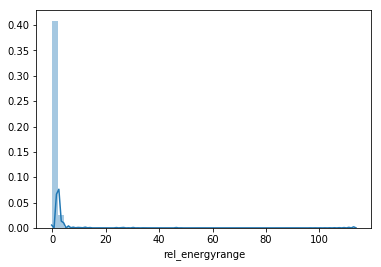

In [79]:
import seaborn as sns
sns.distplot(df['rel_energyrange'])